
Libs



In [2]:
!pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.4 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.35
    Uninstalling SQLAlchemy-2.0.35:
      Successfully uninstalled SQLAlchemy-2.0.35
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [3]:
import pandas  as pd
import numpy as np
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Catalog data

In [2]:
catalog_path = "/content/drive/MyDrive/SEISMIC_DATA/apollo12_catalog_GradeA_final.csv"
catalog_dataframe = pd.read_csv(catalog_path)
catalog_dataframe.head()

filename time_abs(%Y-%m-%dT%H:%M:%S.%f)  \
0  xa.s12.00.mhz.1970-01-19HR00_evid00002     1970-01-19T20:25:00.000000   
1  xa.s12.00.mhz.1970-03-25HR00_evid00003     1970-03-25T03:32:00.000000   
2  xa.s12.00.mhz.1970-03-26HR00_evid00004     1970-03-26T20:17:00.000000   
3  xa.s12.00.mhz.1970-04-25HR00_evid00006     1970-04-25T01:14:00.000000   
4  xa.s12.00.mhz.1970-04-26HR00_evid00007     1970-04-26T14:29:00.000000   

   time_rel(sec)       evid    mq_type  
0        73500.0  evid00002  impact_mq  
1        12720.0  evid00003  impact_mq  
2        73020.0  evid00004  impact_mq  
3         4440.0  evid00006  impact_mq  
4        52140.0  evid00007    deep_mq

Create Training Dataset

In [3]:
def get_seed_dataframe(filename):
    st = read(filename)

    # Initialize a list to store DataFrames for each trace
    data_frames = []

    for tr in st:
        # Get the start time of the trace
        start_time = tr.stats.starttime

        # Compute absolute time by adding relative times to the start time
        absolute_times = [start_time + t for t in tr.times('relative')]

        # Format the absolute time to the required format: '%Y-%m-%dT%H:%M:%S.%f'
        formatted_times = [t.strftime('%Y-%m-%dT%H:%M:%S.%f') for t in absolute_times]

        # Create a DataFrame with formatted time and data
        data = {
            'time_abs': formatted_times,
            'time_rel': tr.times('relative'),  # Relative times in seconds
            'velocity': tr.data  # Seismic data
        }

        df = pd.DataFrame(data)
        data_frames.append(df)

    # Combine DataFrames for all traces into one
    final_df = pd.concat(data_frames, ignore_index=True)

    return final_df


def process_dataframes(folder='/content/drive/MyDrive/SEISMIC_DATA/Lunar_Training'):
    joined_df = pd.DataFrame()
    data_frames = []
    for i, archivo in enumerate(os.listdir(folder)):
        ruta_completa = os.path.join(folder, archivo)
        print(f'Processing: {ruta_completa}')
        temp_df_miniseed = get_seed_dataframe(ruta_completa)
        temp_df_miniseed['Seismic_Arrival'] = 0 # Column to label arrival (red lines)

        #mq_type = catalog_dataframe.loc[catalog_dataframe['filename'] == archivo[:-6], 'mq_type'] # Get the mq_type for  correct file (can be useful in the UI)

        temp_arrival = catalog_dataframe.loc[catalog_dataframe['filename'] == archivo[:-6], 'time_rel(sec)'] # Get the time_rel for the correct file

        #try:
          #mq_type = mq_type.values[0] # Real mq_type
        #except:
          #mq_type = "Not Found" # A value doesn't exist

        try:
            temp_arrival = temp_arrival.values[0] # Real temp arrival
        except:
            pass # One miniseed has an incorrect name

        print(temp_arrival)

        #temp_df_miniseed["mq_type"] = mq_type

        temp_df_miniseed["Relative_Time_Int"] = temp_df_miniseed["time_rel"].apply(lambda x: int(x)) # We noticed that we have multiple arrives in one second

        temp_df_miniseed.loc[temp_df_miniseed['Relative_Time_Int'] == temp_arrival, 'Seismic_Arrival'] = 1 #Replace values where we know there was a red line with 1 label

        first_index = temp_df_miniseed[temp_df_miniseed['Seismic_Arrival'] == 1].index[0] # We are not interested in datapoints before the arrival

        temp_df_miniseed = temp_df_miniseed.loc[first_index:].reset_index(drop=True)

        num_indices_to_keep = 30 # num of indexes to keep after the arrival, we need to decrease unbalanced classes.
        if len(temp_df_miniseed) > num_indices_to_keep:
            temp_df_miniseed = temp_df_miniseed.iloc[:num_indices_to_keep]
        else:
            temp_df_miniseed = temp_df_miniseed.iloc[:1] # If we passed 30 , we just keep the arrival

        data_frames.append(temp_df_miniseed)

    return data_frames

In [4]:
labeled_dataframes = process_dataframes()
label_training = pd.concat(labeled_dataframes, ignore_index=True)

Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed
73500.0
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-03-25HR00_evid00003.mseed
12720.0
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-03-26HR00_evid00004.mseed
73020.0
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-04-25HR00_evid00006.mseed
4440.0
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-04-26HR00_evid00007.mseed
52140.0
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-06-15HR00_evid00008.mseed
68400.0
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-06-26HR00_evid00009.mseed
72060.0
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-07-20HR00_evid00010.mseed
18360.0
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.

In [5]:
label_training["Seismic_Arrival"].value_counts()

Seismic_Arrival
0    1725
1     525
Name: count, dtype: int64

Balanced Random Forest

In [6]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [8]:
X = label_training.drop(['time_abs', 'time_rel','Seismic_Arrival'], axis=1) #Will use just velocity and Relative_Time_Int
y = label_training['Seismic_Arrival']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [9]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier(random_state=42)

In [10]:
y_pred = brf.predict(X_test)

In [11]:
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       337
           1       0.88      1.00      0.94       113

    accuracy                           0.97       450
   macro avg       0.94      0.98      0.96       450
weighted avg       0.97      0.97      0.97       450



In [30]:
sample = "/content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed"
training_sample = get_seed_dataframe(sample)
arrival_time_rel = 73500

training_sample["Relative_Time_Int"] = training_sample["time_rel"].apply(lambda x: int(x))

training_sample_process = training_sample.drop(['time_abs', 'time_rel'], axis=1)

training_sample["Predicted_Seismic_Arrival"] = brf.predict(training_sample_process)


In [42]:
red_line_times = training_sample.loc[training_sample['Predicted_Seismic_Arrival'] == 1, 'Relative_Time_Int'].unique()

red_line_times

array([    0,     1,     2, ..., 84658, 84659, 84660])

In [47]:
len(red_line_times)

42929

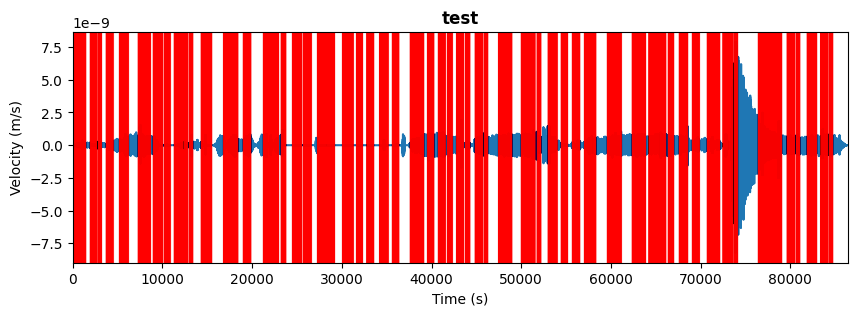

In [46]:
# Read in time steps and velocities
csv_times = np.array(training_sample['time_rel'].tolist())
csv_data = np.array(training_sample['velocity'].tolist())
# Plot the trace!
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)
# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'test', fontweight='bold')

for time in red_line_times:
    plt.axvline(x=time, color='red', linestyle='solid', alpha=0.1)

# Plot where the arrival timswe is
#arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
#ax.legend(handles=[arrival_line])

Test Data

In [60]:
def process_test_dataframes(folder='/content/drive/MyDrive/SEISMIC_DATA/Lunar_Testing'):
    joined_df = pd.DataFrame()
    data_frames = []
    for i, archivo in enumerate(os.listdir(folder)):
        ruta_completa = os.path.join(folder, archivo)

        print(f'Processing: {ruta_completa}')
        temp_df_miniseed = get_seed_dataframe(ruta_completa)

        temp_df_miniseed["Relative_Time_Int"] = temp_df_miniseed["time_rel"].apply(lambda x: int(x)) # We noticed that we have multiple arrives in one second

        data_frames.append(temp_df_miniseed)

    return data_frames


In [62]:
test_dataframes = process_test_dataframes(folder="/content/drive/MyDrive/SEISMIC_DATA/Lunar_Testing_Small")

Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Testing_Small/xa.s16.00.mhz.1977-04-17HR00_evid00249.mseed
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Testing_Small/xa.s16.00.mhz.1975-03-26HR00_evid00186.mseed
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Testing_Small/xa.s16.00.mhz.1972-11-06HR00_evid00079.mseed
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Testing_Small/xa.s16.00.mhz.1977-06-02HR00_evid00255.mseed
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Testing_Small/xa.s16.00.mhz.1972-11-08HR00_evid00080.mseed
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Testing_Small/xa.s16.00.mhz.1974-12-15HR00_evid00172.mseed
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Testing_Small/xa.s16.00.mhz.1974-12-12HR02_evid00168.mseed
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Testing_Small/xa.s16.00.mhz.1974-11-11HR00_evid00160.mseed
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Testing_Small/xa.s16.00.mhz.1974-12-25HR00

In [65]:
test_serie = test_dataframes[0]
test_serie_process = test_serie.drop(['time_abs', 'time_rel'], axis=1)

y_pred = brf.predict(test_serie_process)

test_serie["Arrival_Prediction"] = y_pred

Plotting Some Predictions

In [66]:
test_serie["Arrival_Prediction"].value_counts()

Arrival_Prediction
0    288008
1    284403
Name: count, dtype: int64

# **STA/LTA**

In [4]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset
import math
from obspy import Stream
from obspy.signal.trigger import classic_sta_lta
from scipy import signal
from matplotlib import cm


In [5]:
async def plot_characteristic_function(tr_times,cft):

    fig,ax = plt.subplots(1,1,figsize=(12,3))

    ax.plot(tr_times,cft)
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')


Since we are getting more than one arrive line, we tried to get a max or intermediate point for the red lines on plot arrival as follows:  

```
async def plot_arrival(tr_data,tr_times,on_off):

    fig,ax = plt.subplots(1,1,figsize=(12,3))

    red_lines = []
    for i in np.arange(0,len(on_off)):
      triggers = on_off[i]
      red_line = tr_times[triggers[0]]

    red_lines.append(red_line)
    
    best_red_line = max(red_lines)
    ax.axvline(x = best_red_line, color='red', label='Trig. On')
    ax.plot(tr_times,tr_data)
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.legend()

```

but it perfoms a bit worst and we decided to keep all the red lines.


In [24]:
async def plot_arrival(tr_data,tr_times,on_off):

    fig,ax = plt.subplots(1,1,figsize=(12,3))

    for i in np.arange(0,len(on_off)):
      triggers = on_off[i]
      red_line = tr_times[triggers[0]]
      ax.axvline(x = red_line, color='red', label='Trig. On')

    ax.plot(tr_times,tr_data)
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.legend()

async def plot_spectrum(tr_data_filt,tr_filt,tr_times_filt):

  f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)


  fig = plt.figure(figsize=(10, 10))
  ax = plt.subplot(2, 1, 1)
  # Plot trace
  ax.plot(tr_times_filt,tr_data_filt)
  ax.set_xlim([min(tr_times_filt),max(tr_times_filt)])
  ax.set_ylabel('Velocity (m/s)')
  ax.set_xlabel('Time (s)')
  ax2 = plt.subplot(2, 1, 2)
  vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
  ax2.set_xlim([min(tr_times_filt),max(tr_times_filt)])
  ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
  ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
  cbar = plt.colorbar(vals, orientation='horizontal')
  cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')




At "process_miniseed" function we tried with multiple values to get stablished sta_len and lta_len and we tried the next approaches to get thr_off and thr_on:

- thr_on an maximum value with thr_off as a value iin the interval (1,thr_on):

```
        thr_on = max(cft) #didn't work
        test_array = np.array(cft)
        filtered_array = test_array[(test_array != np.max(test_array)) & (test_array > 1)]

        thr_off = np.random.choice(filtered_array) #didn't work

        print(thr_off)
        print(thr_on)
```

- create distance variable and assign thr_on as maximum distance and thr_off and min distance

```
        distance = tr_data*tr_times #didn't work
        thr_on = np.max(distance) #didn't work
        thr_off = np.min(distance)

        print(thr_off)
        print(thr_on)
```

- use 95% percentil as thr_on and min or mean as thr_off


```
        thr_on = np.percentile(cft, 95) # works better

        filtered_array = cft[cft < thr_on]

        if len(filtered_array) > 0:
            thr_off = np.mean(filtered_array)
        else:
            thr_off = np.min(cft)

        print(thr_off)
        print(thr_on)

```

Apart of that we introduce a code to test spectograms but it performs poorly :



```
        minfreq = 0.01  # Minimum frequency in Hz
        maxfreq = 0.5  # Maximum frequency in Hz

        # Create a separate trace for the filtered data
        st_filt = Stream()
        st_filt.append(tr.copy())  # Append the original trace to the new Stream

        # Apply bandpass filter
        st_filt.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)
        tr_filt = st_filt.traces[0].copy()

        # Get filtered trace data and times
        tr_times_filt = tr_filt.times()
        tr_data_filt = tr_filt.data


        spectrum = await plot_spectrum(tr_data_filt,tr_filt,tr_times_filt)  

```








In [25]:
async def process_miniseed(folder='/content/drive/MyDrive/SEISMIC_DATA/Lunar_Training'):
    data_frames = []
    for i, archivo in enumerate(os.listdir(folder)):
        ruta_completa = os.path.join(folder, archivo)
        print(f'Processing: {ruta_completa}')
        temp_miniseed = read(ruta_completa)

        tr = temp_miniseed.traces[0].copy()

        tr_data = tr.data
        tr_times = tr.times()

        df = tr.stats.sampling_rate

        sta_len = 60 # Seconds (After test some values this worked)
        lta_len = 20000

        cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df)) # Run Obspy's STA/LTA to obtain a characteristic function


        thr_on = np.percentile(cft, 95)

        filtered_array = cft[cft < thr_on]

        if len(filtered_array) > 0:
            thr_off = np.mean(filtered_array)
        else:
            thr_off = np.min(cft)

        print(thr_off)
        print(thr_on)

        on_off = np.array(trigger_onset(cft, thr_on, thr_off))

        characteristic = await plot_characteristic_function(tr_times,cft)

        arrival = await plot_arrival(tr_data,tr_times,on_off)




Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed
0.5916812681252291
5.417290640999704
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-03-25HR00_evid00003.mseed
0.5712056179713255
1.3268087522742906
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-03-26HR00_evid00004.mseed
0.5469694270687954
1.505555916989948
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-04-25HR00_evid00006.mseed
0.5639794913958732
1.8748208502634884
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-04-26HR00_evid00007.mseed
0.6028379522355757
1.818603904605494
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-06-15HR00_evid00008.mseed
0.4693582593826207
3.4407916903397675
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-06-26HR00_evid00009.mseed
0.6270054954010399


<ipython-input-5-693f2c792269>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,1,figsize=(12,3))


Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-11-12HR00_evid00015.mseed
0.5356564594839464
3.1755157630211355
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-12-27HR00_evid00019.mseed
0.6292748572931808
1.338113869058657
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-12-11HR00_evid00017.mseed
0.49488522733906215
2.7424829778636606
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1970-12-31HR00_evid00021.mseed
0.5206405787631937
1.252504879277264
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1971-01-15HR00_evid00022.mseed
0.2000742613059383
2.2261230215635637
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1971-01-29HR00_evid00024.mseed
0.5188478436808348
1.2991580511942853
Processing: /content/drive/MyDrive/SEISMIC_DATA/Lunar_Training/xa.s12.00.mhz.1971-01-28HR00_evid00023.mseed
0.423995462066129

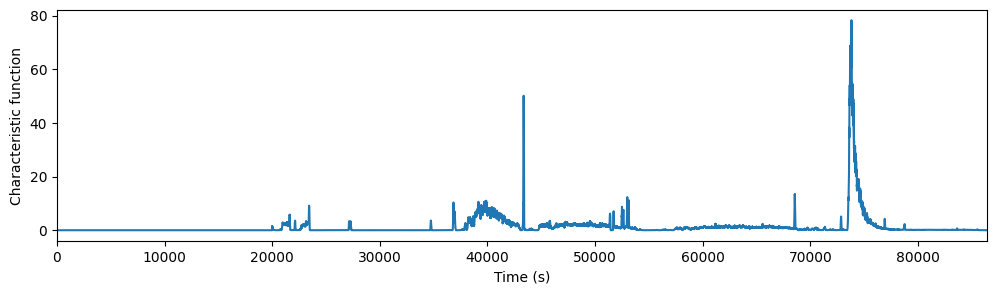

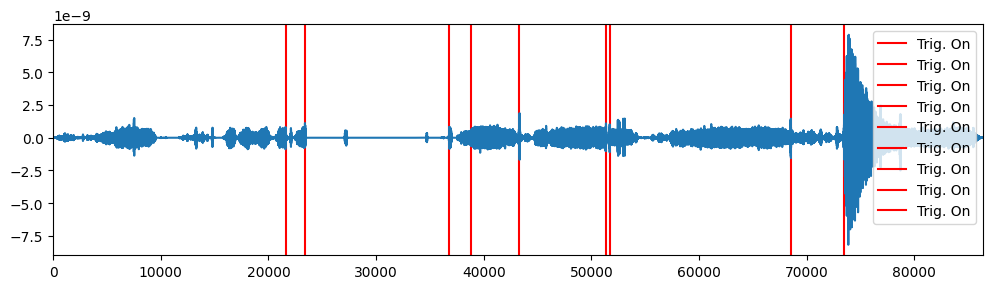

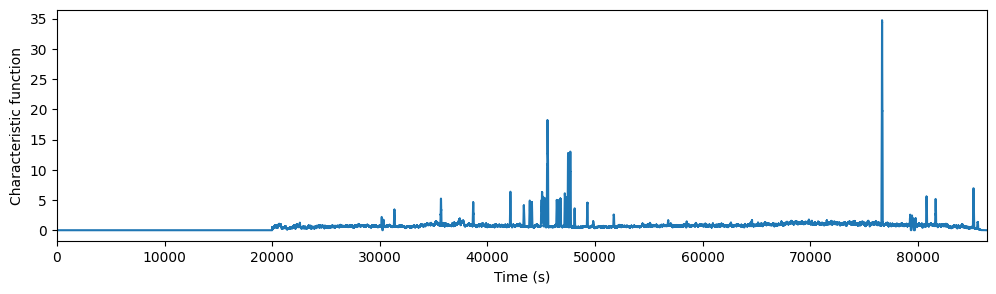

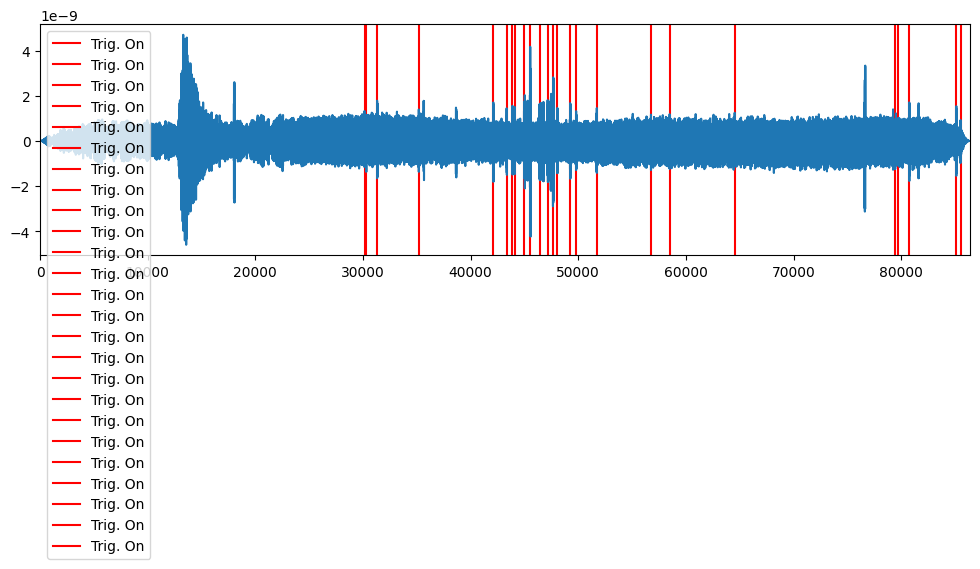

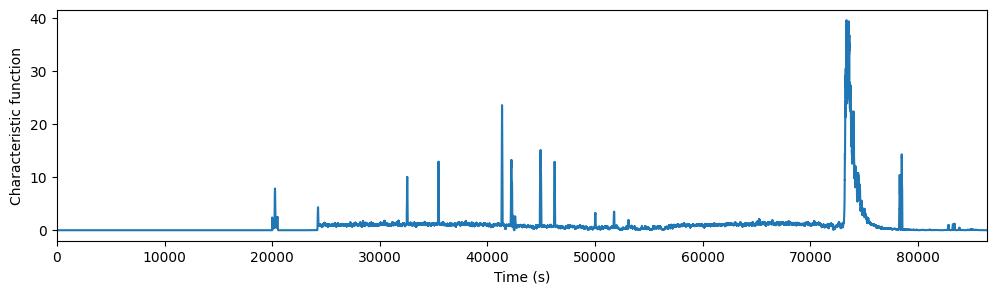

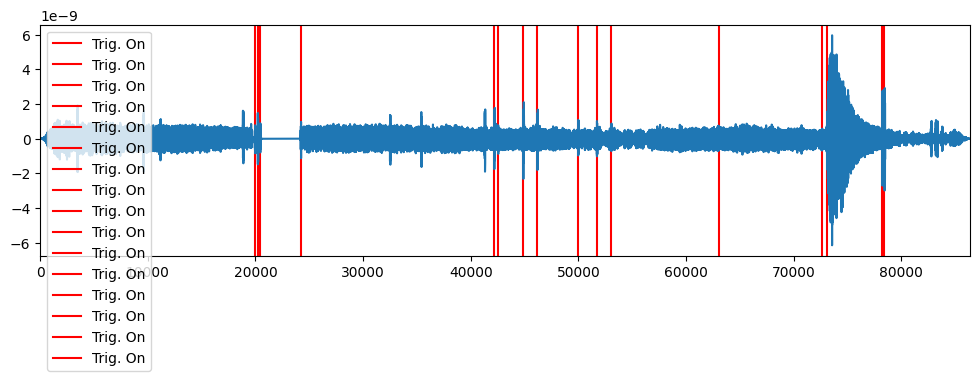

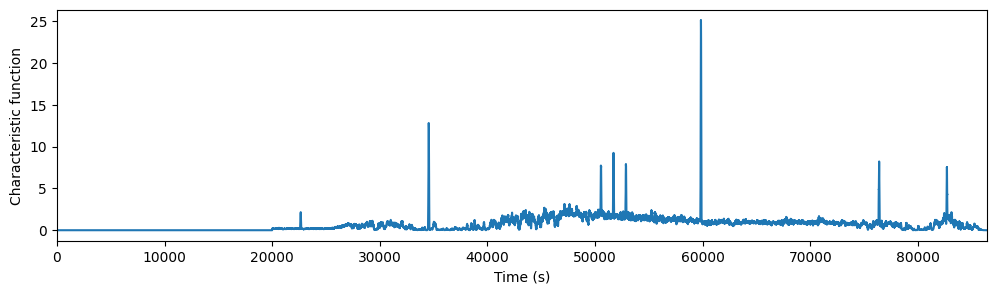

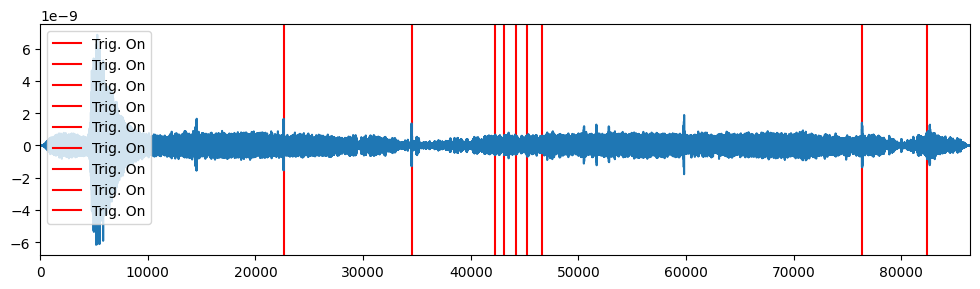

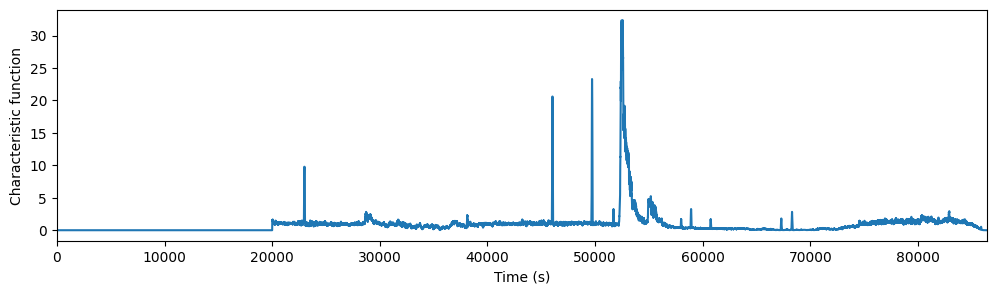

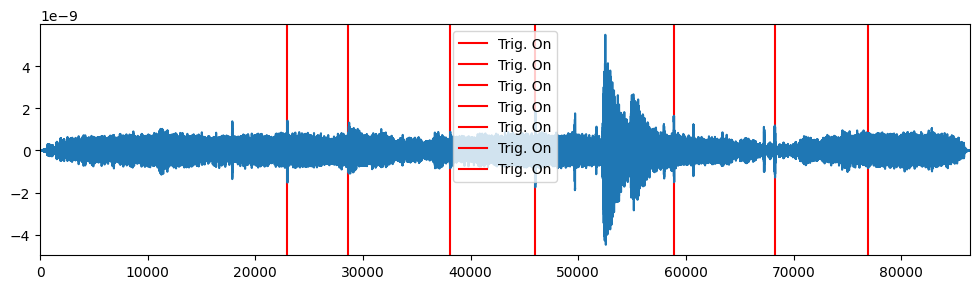

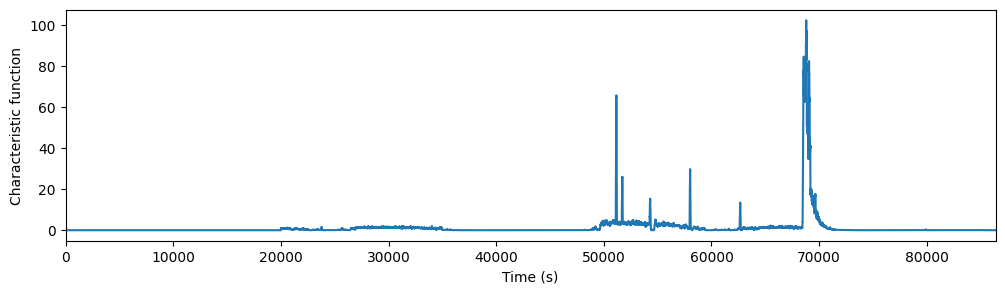

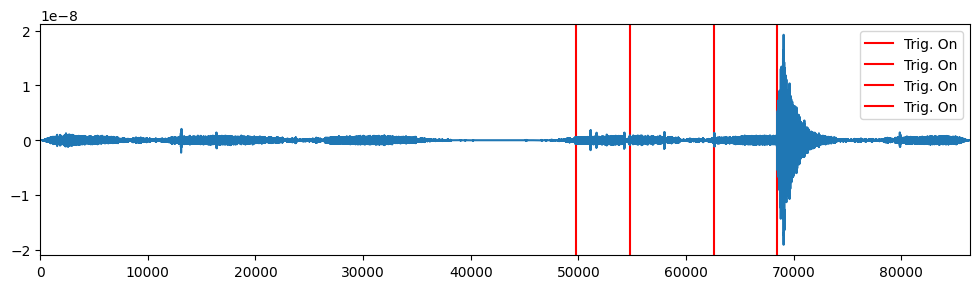

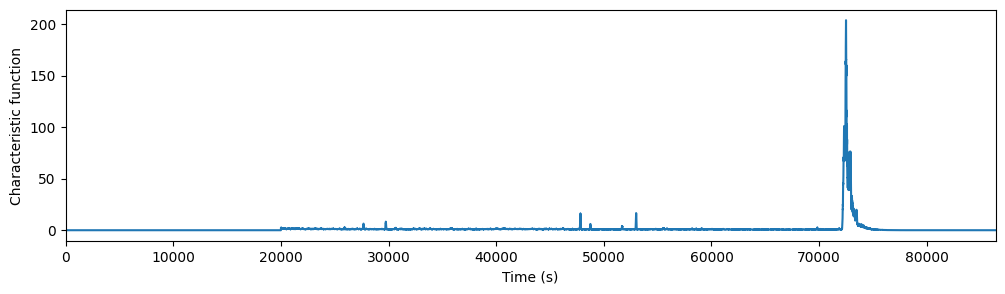

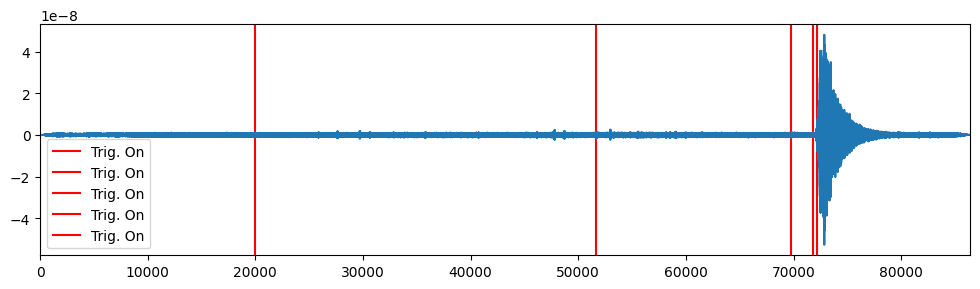

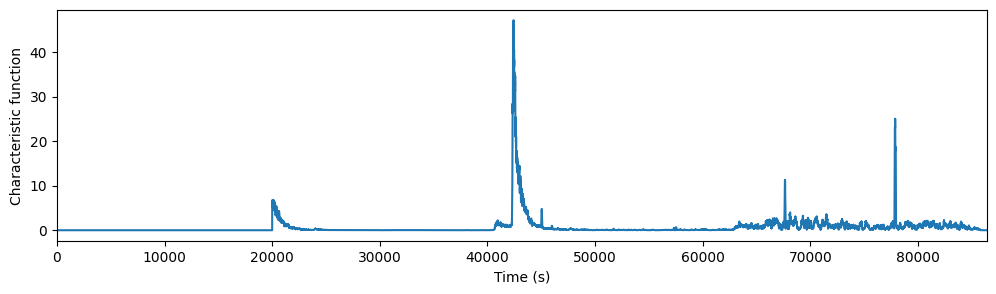

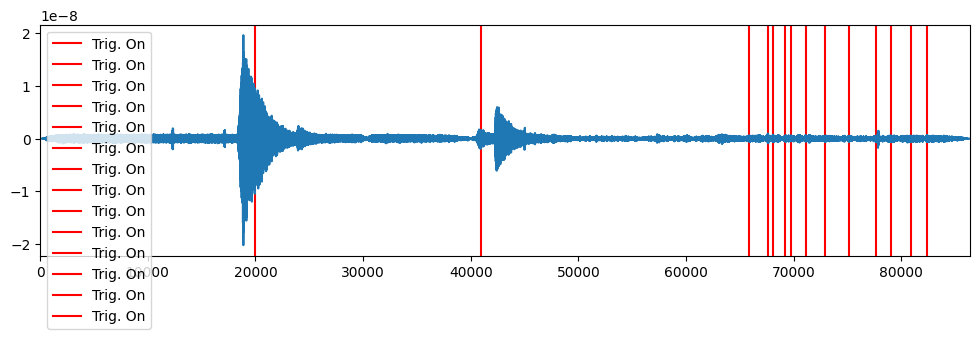

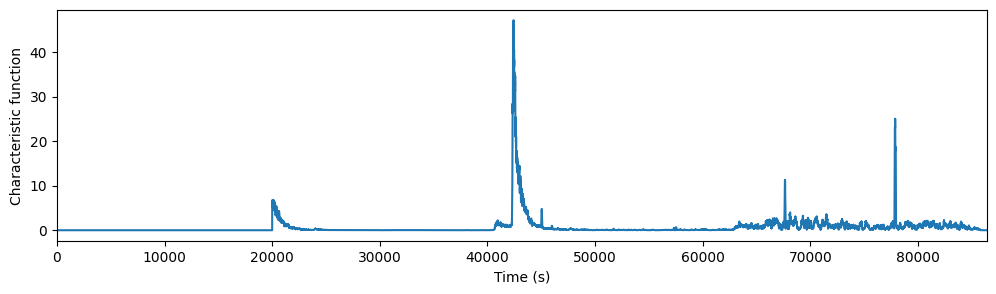

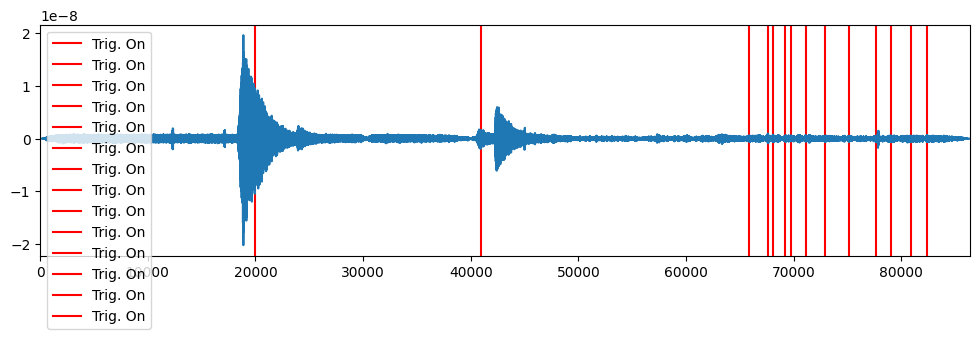

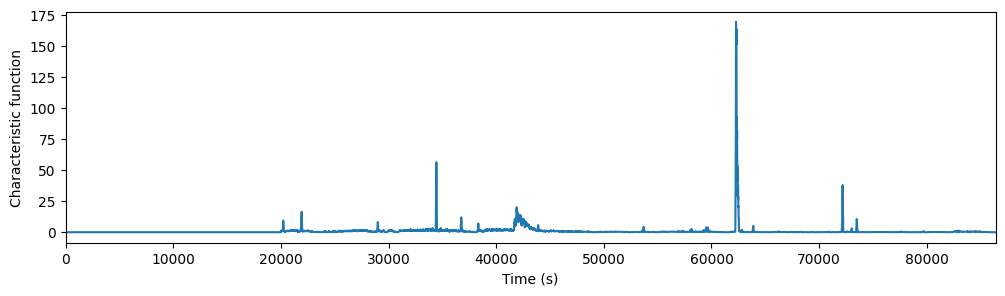

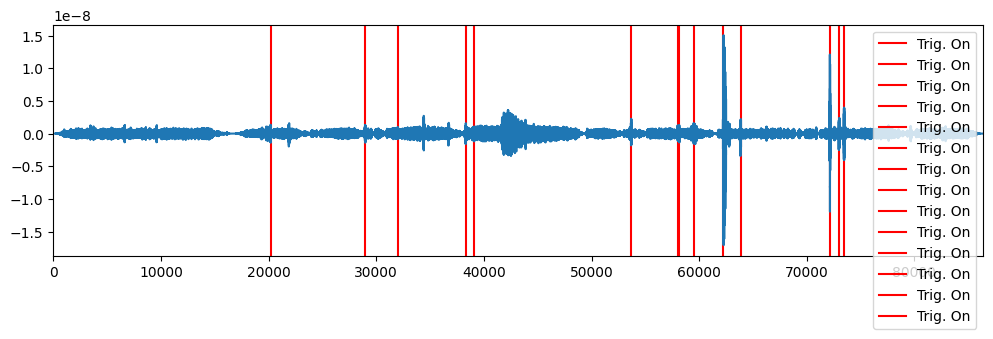

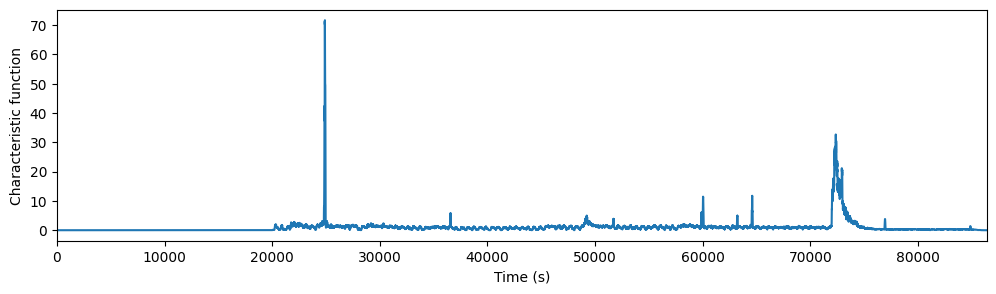

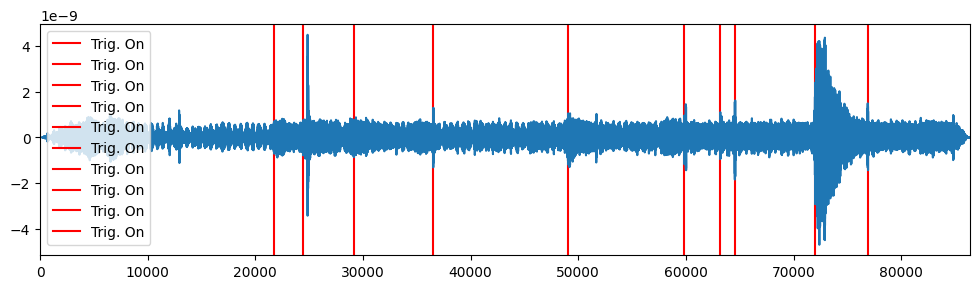

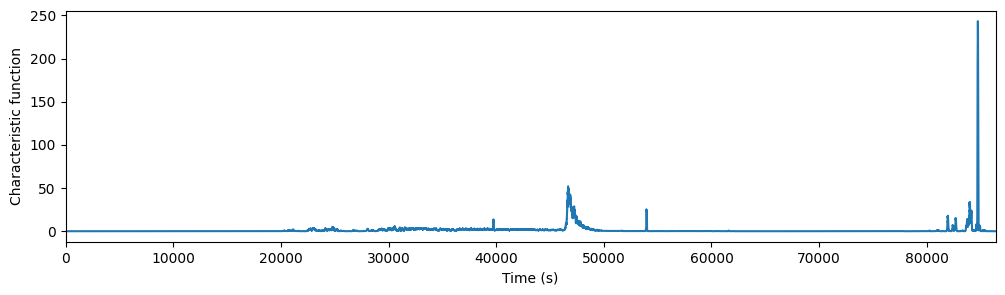

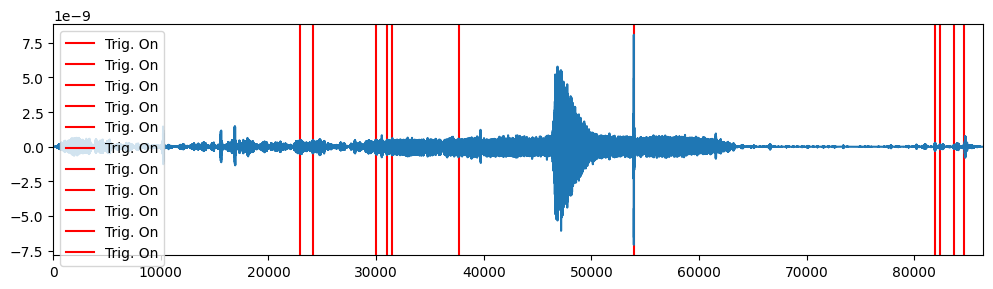

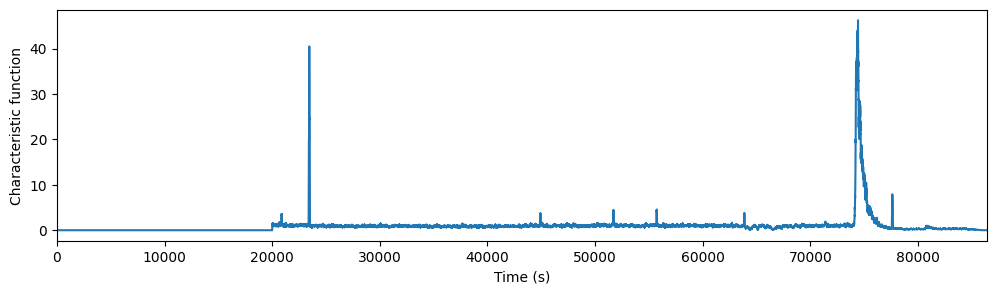

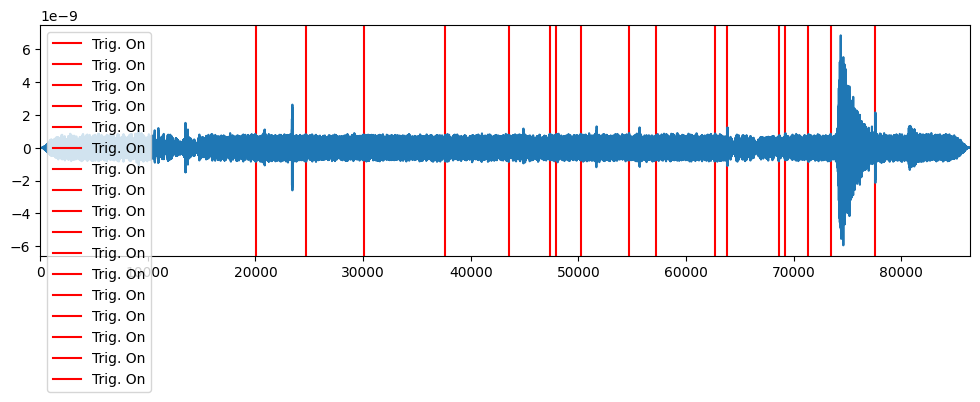

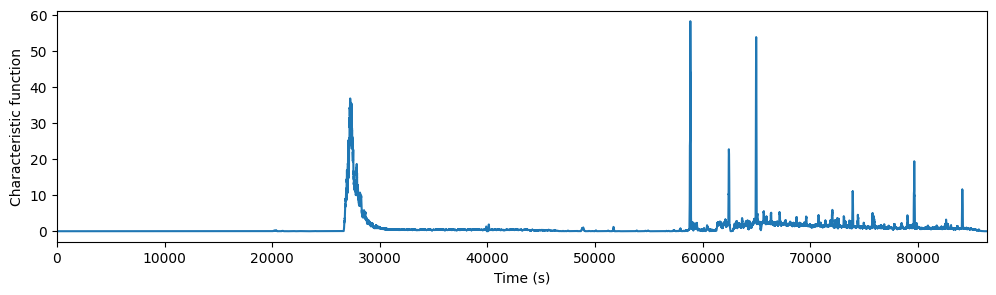

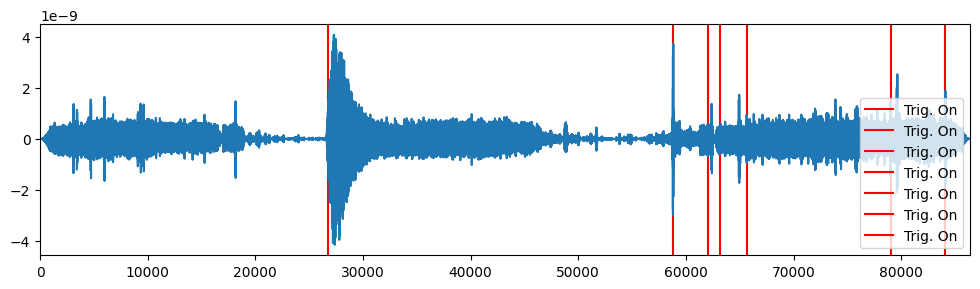

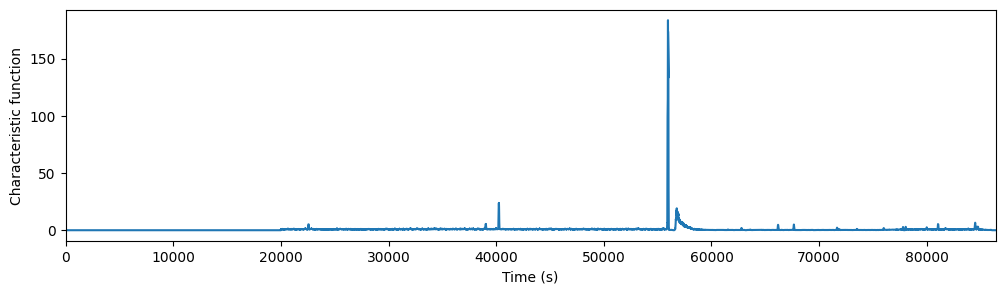

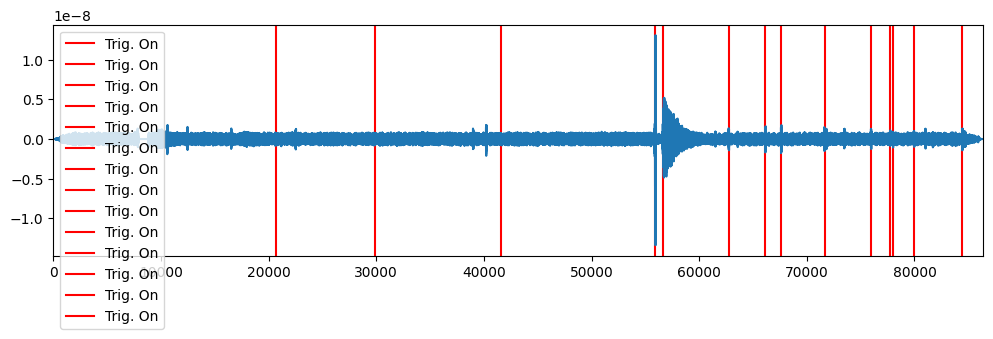

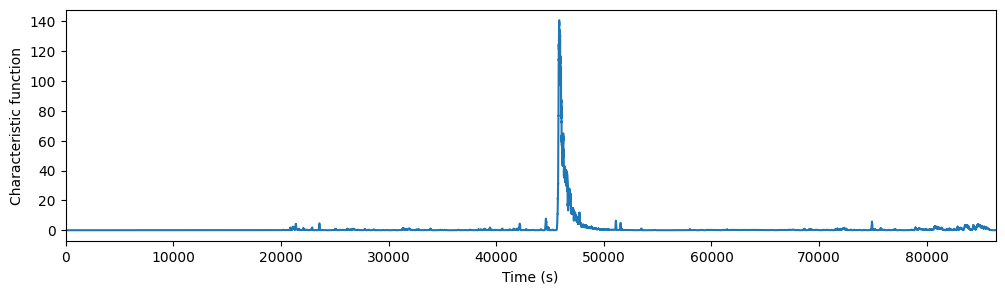

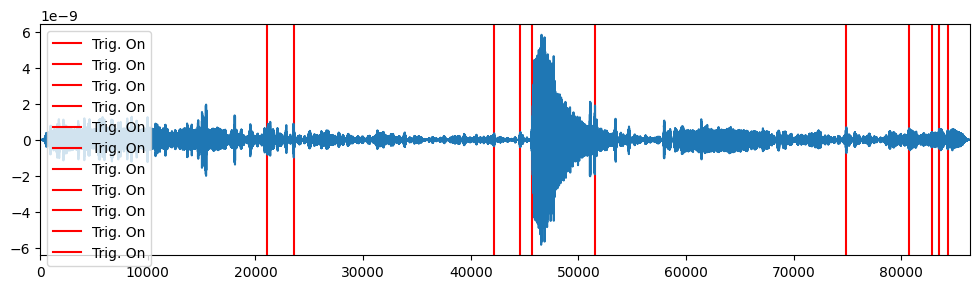

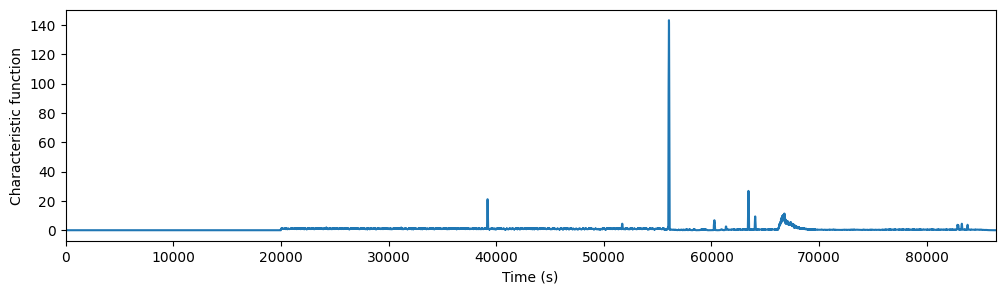

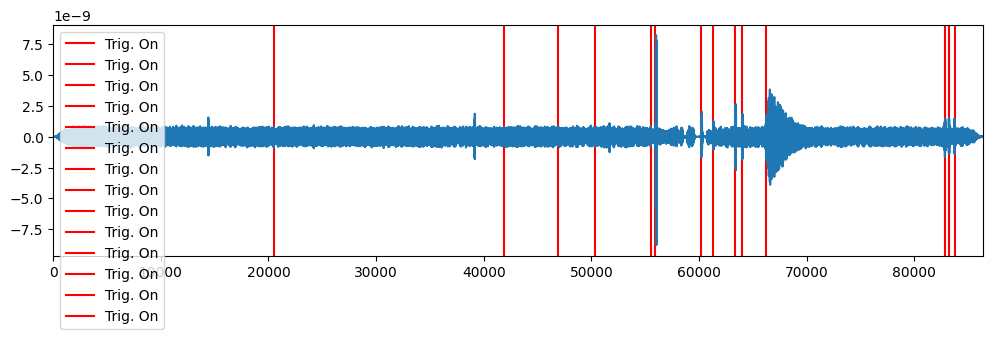

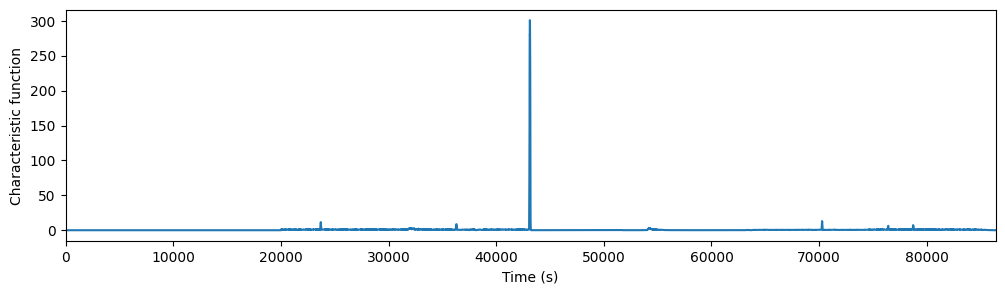

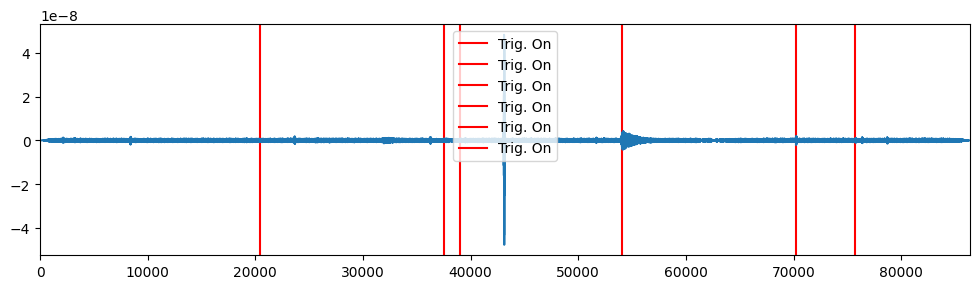

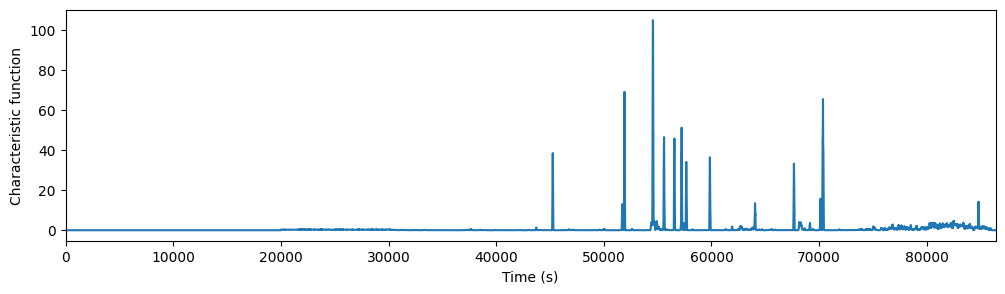

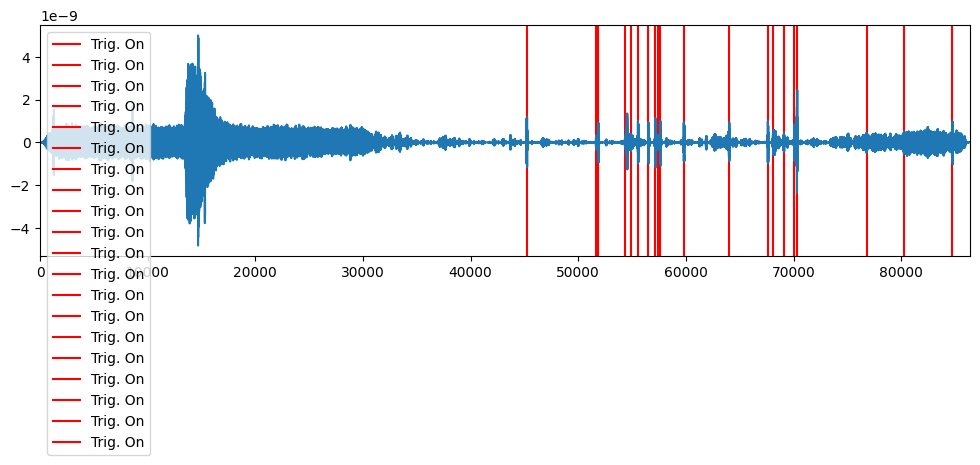

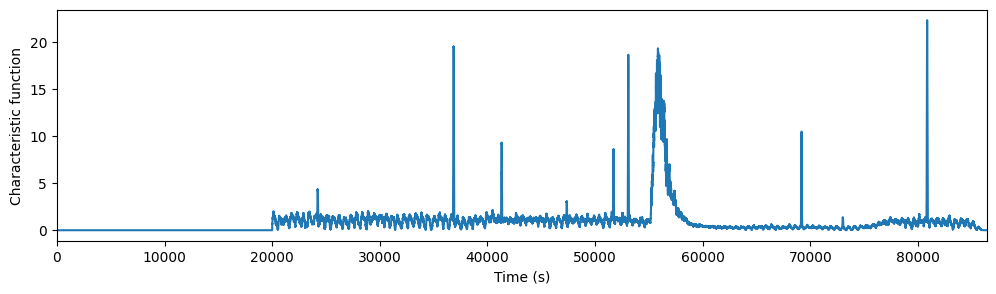

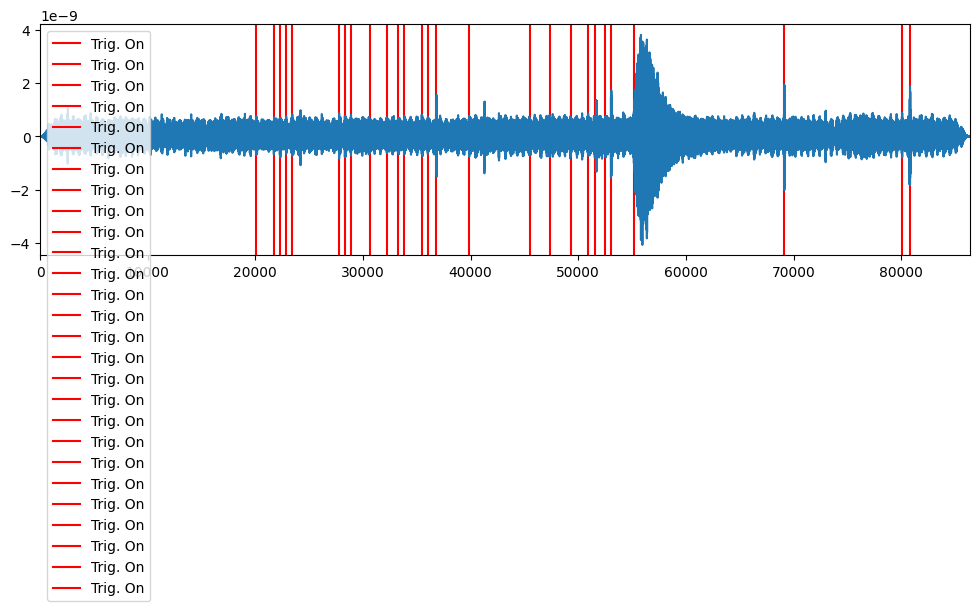

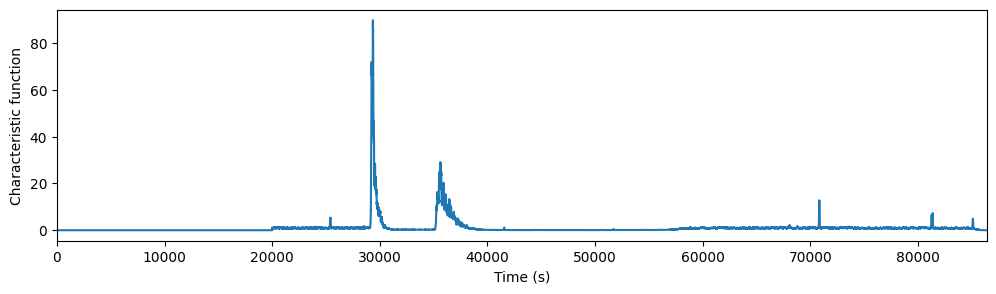

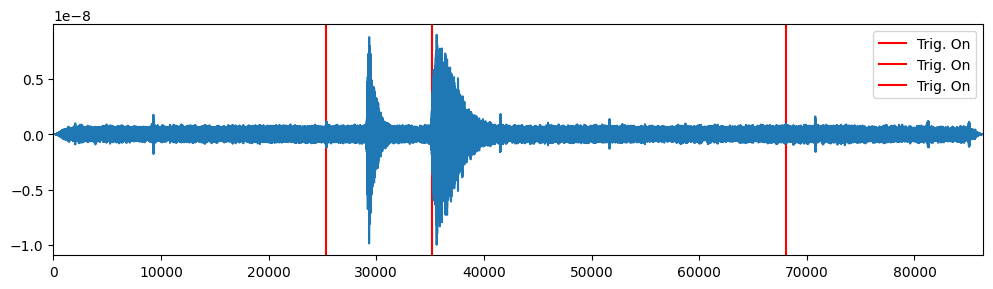

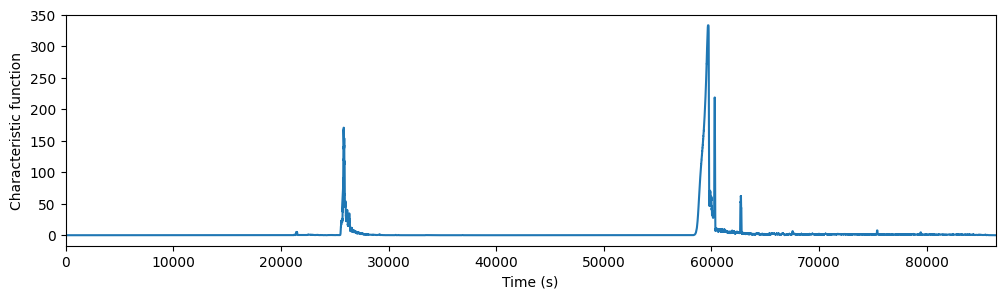

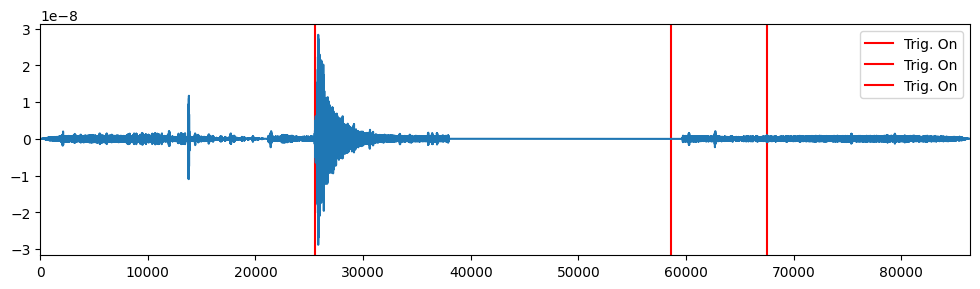

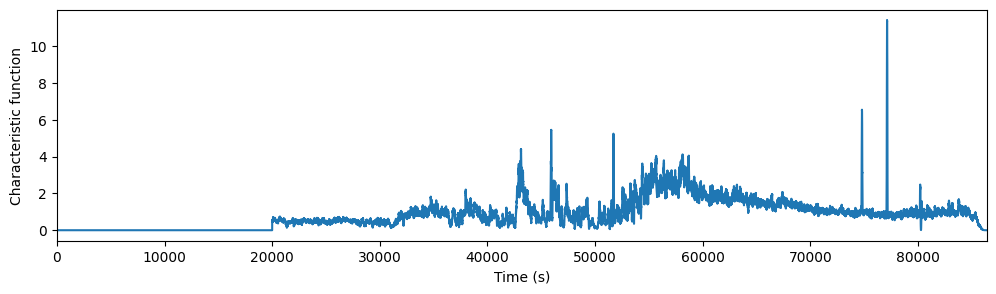

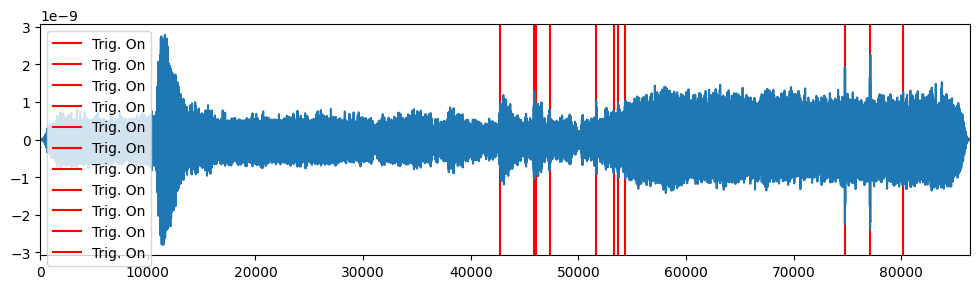

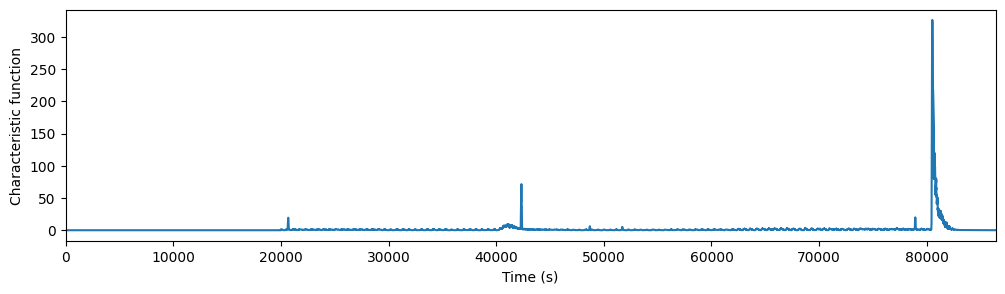

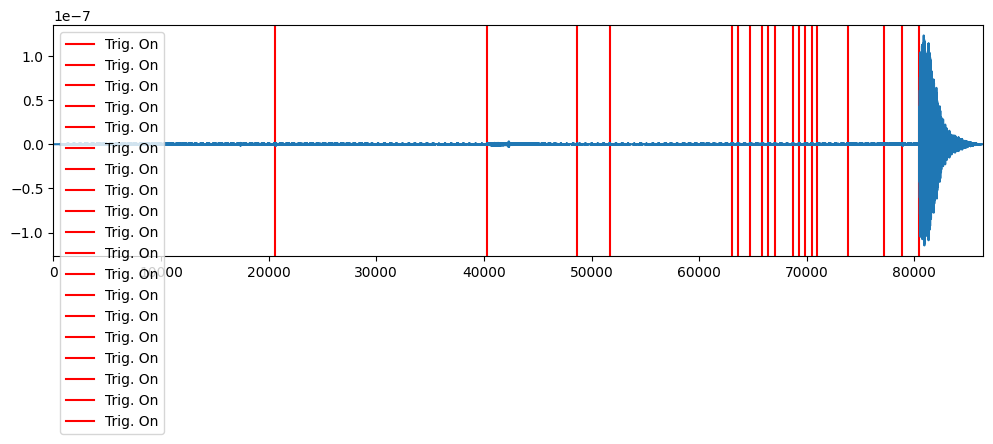

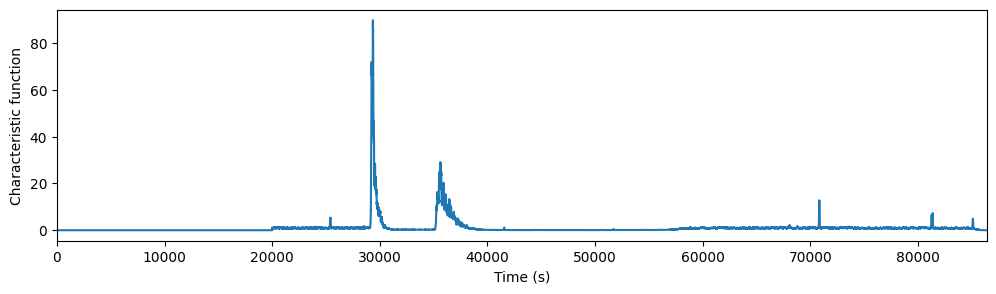

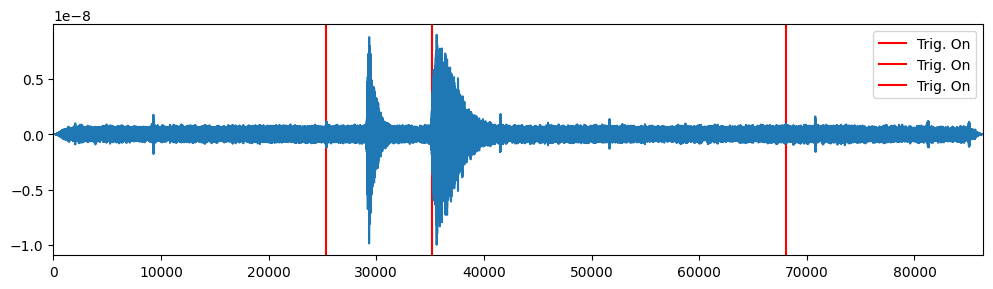

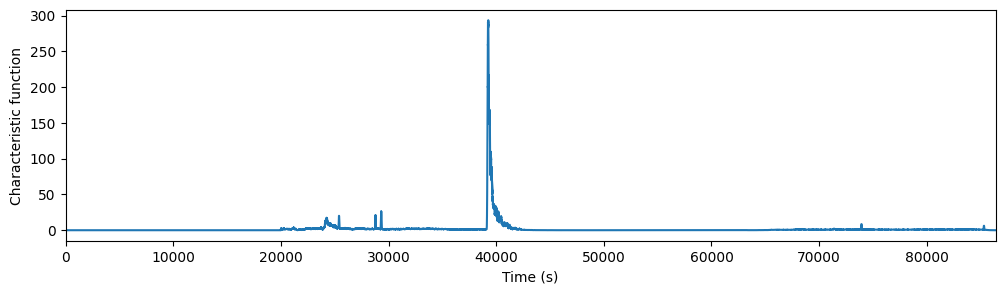

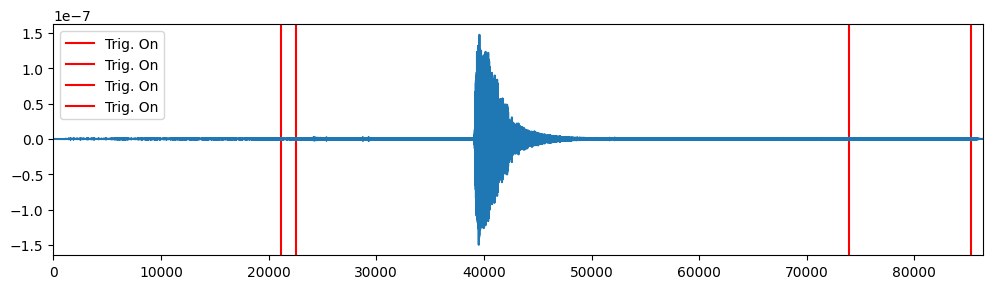

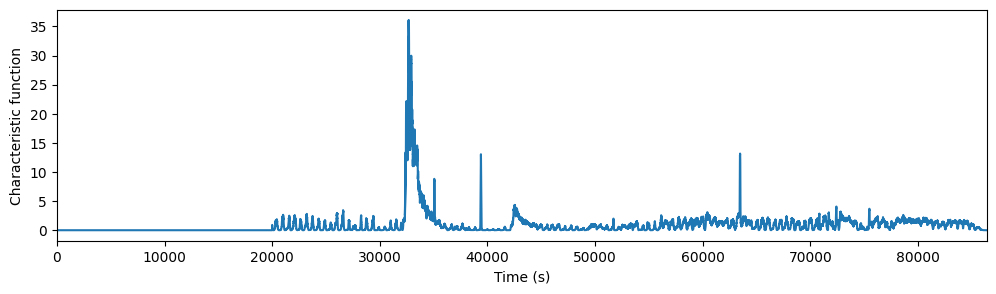

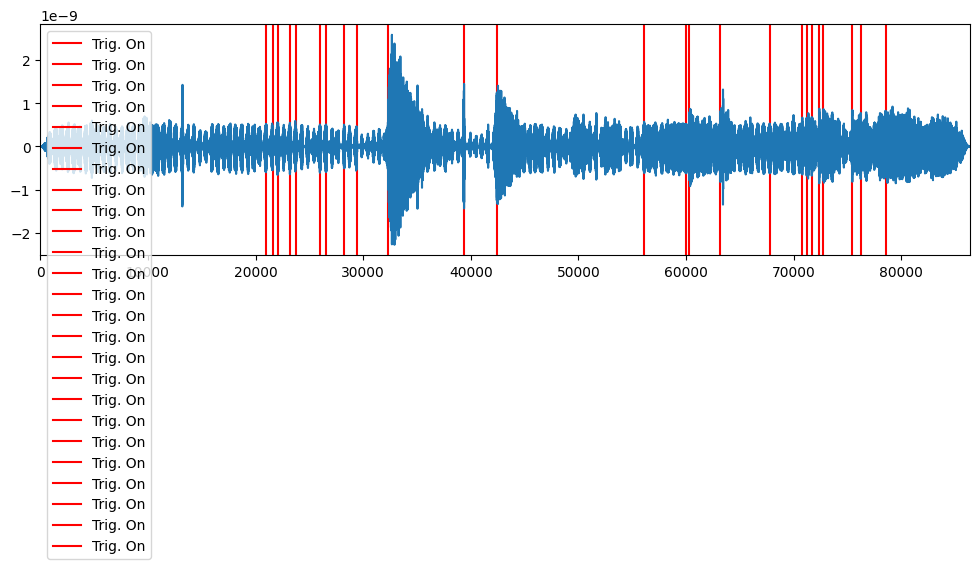

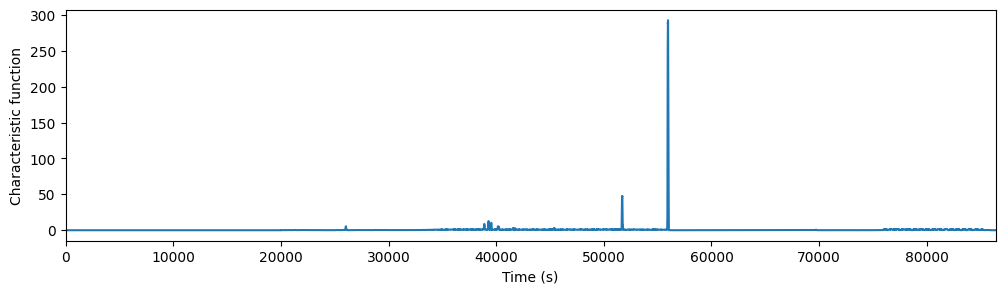

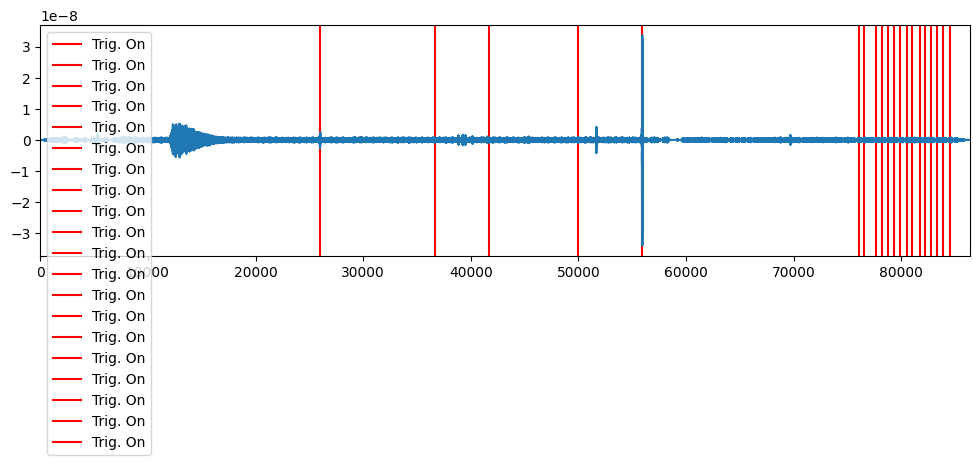

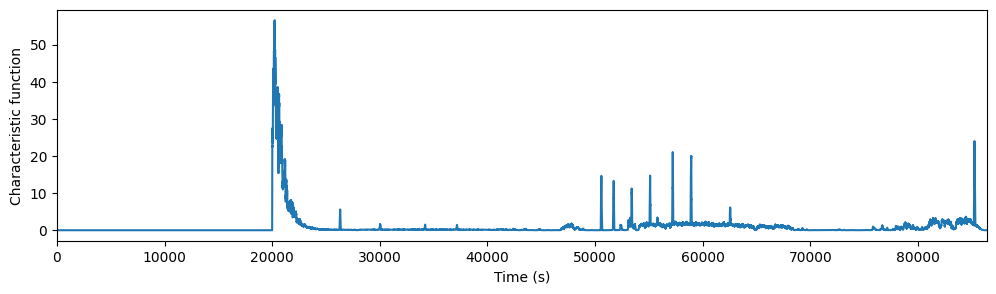

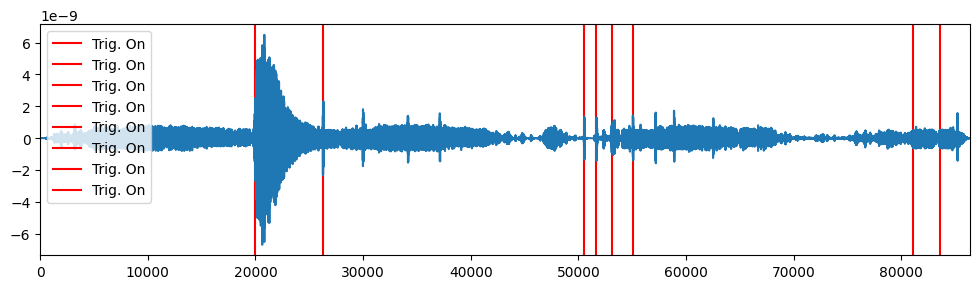

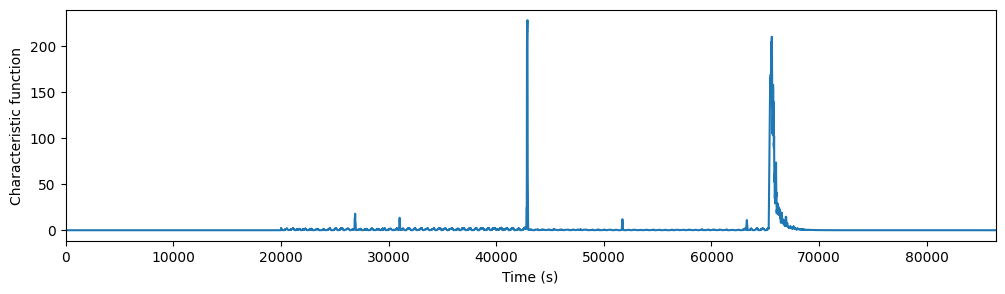

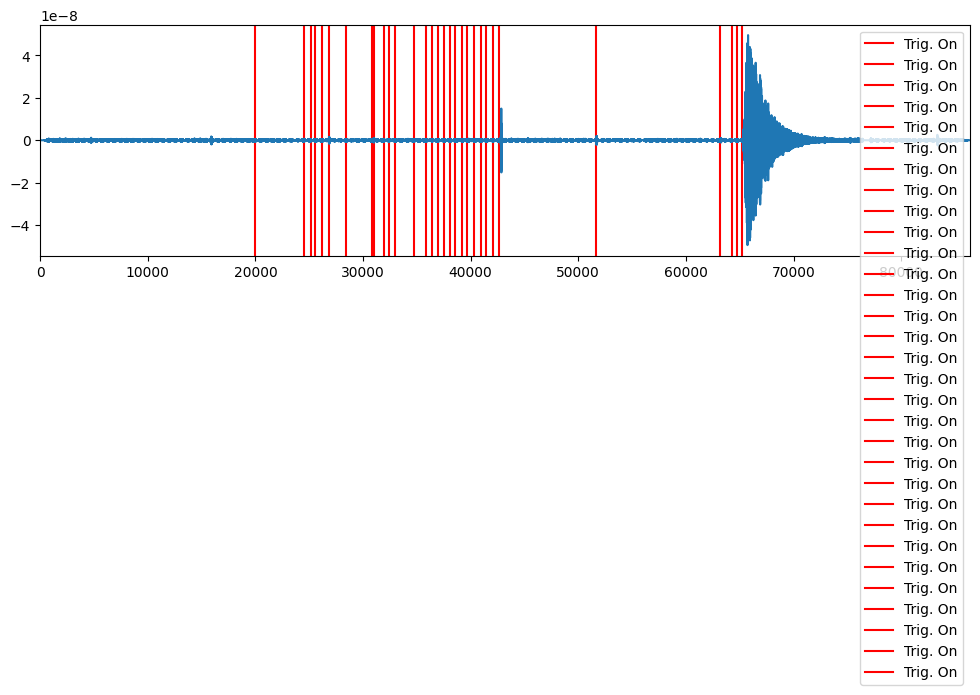

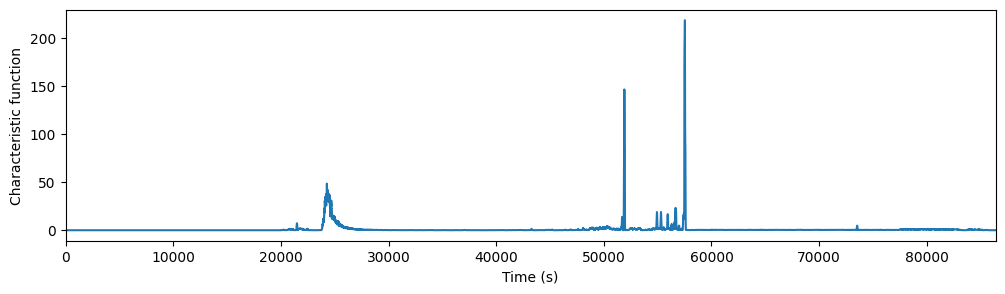

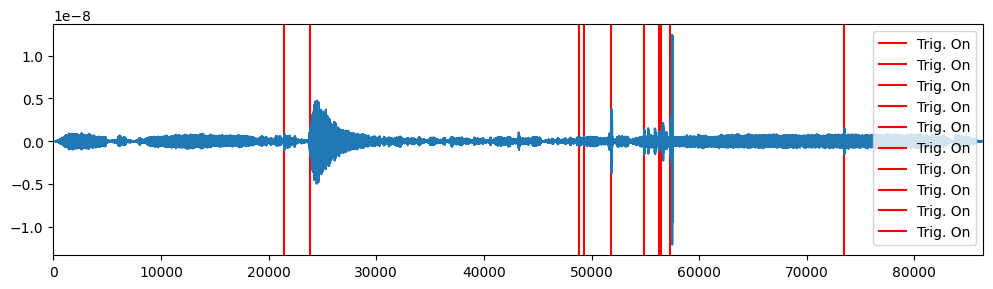

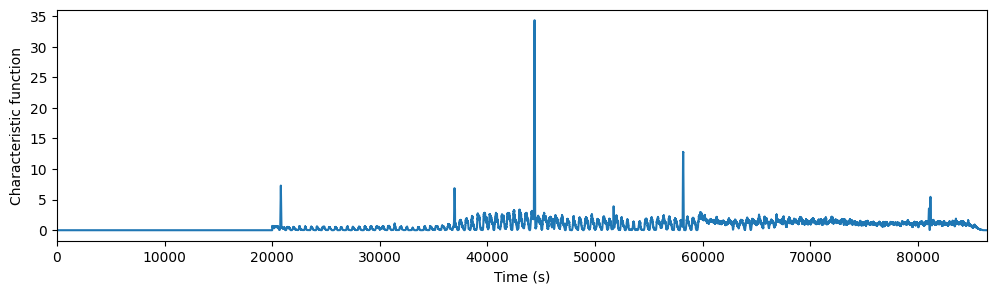

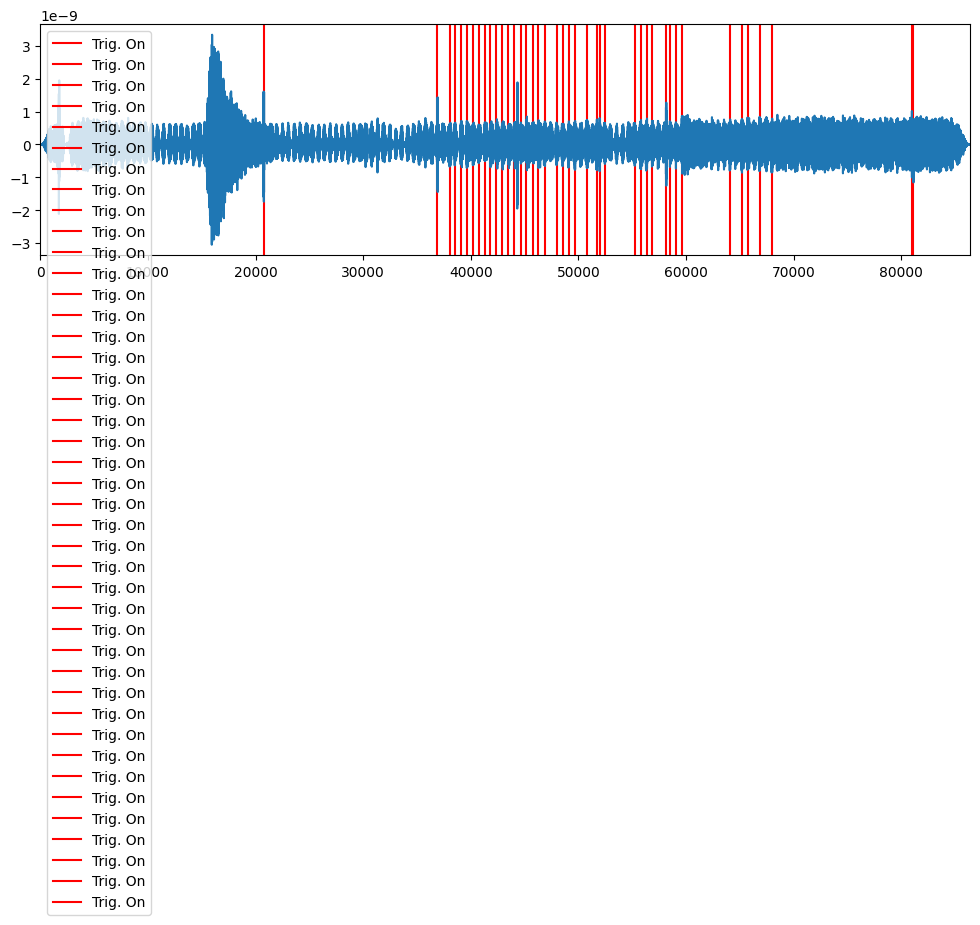

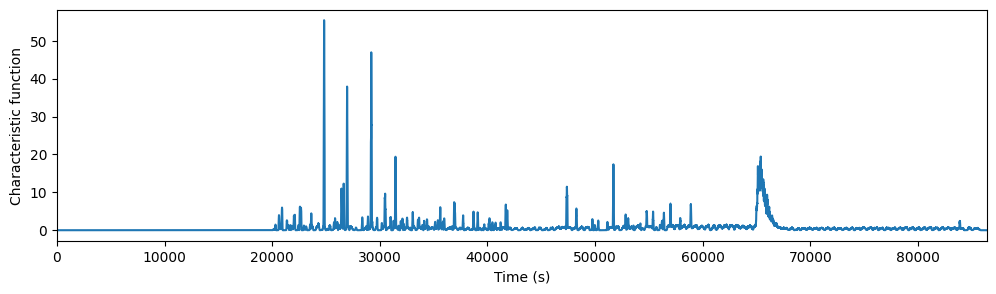

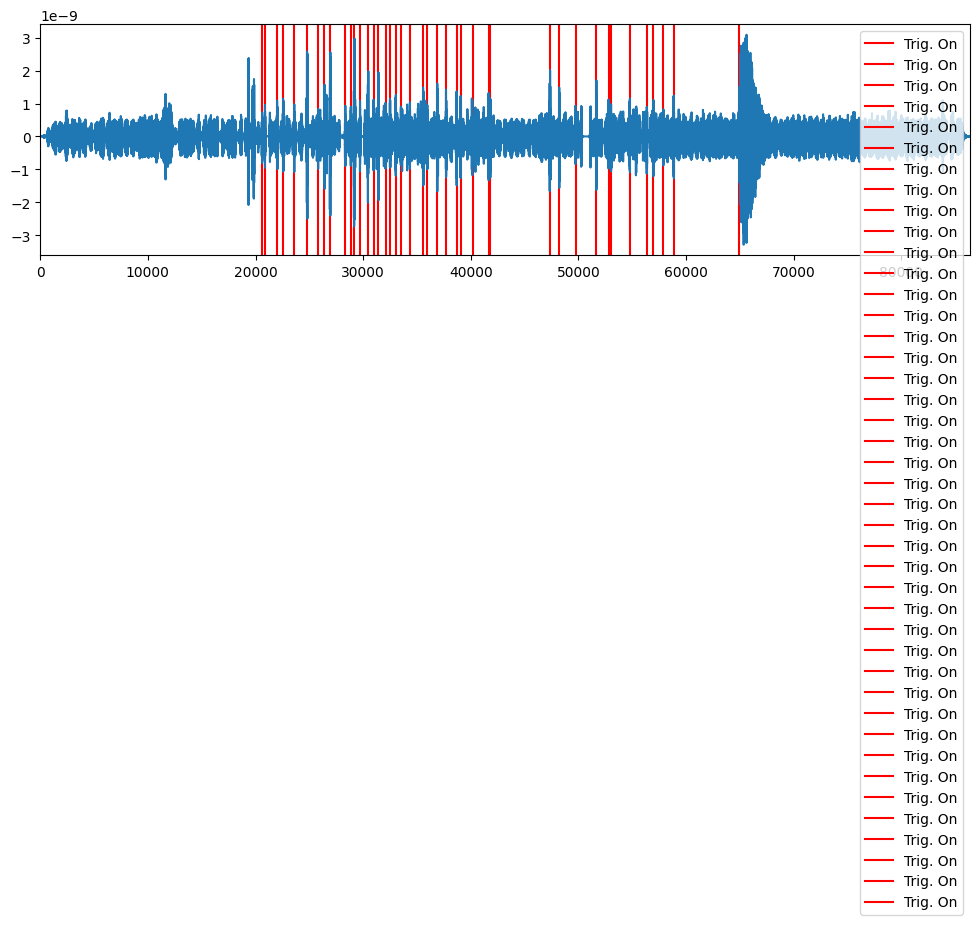

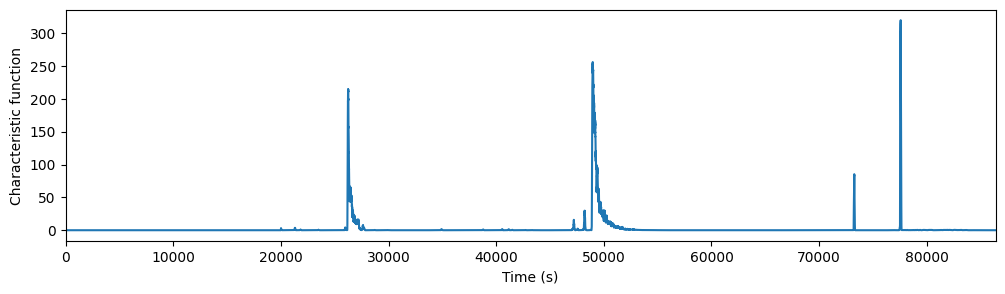

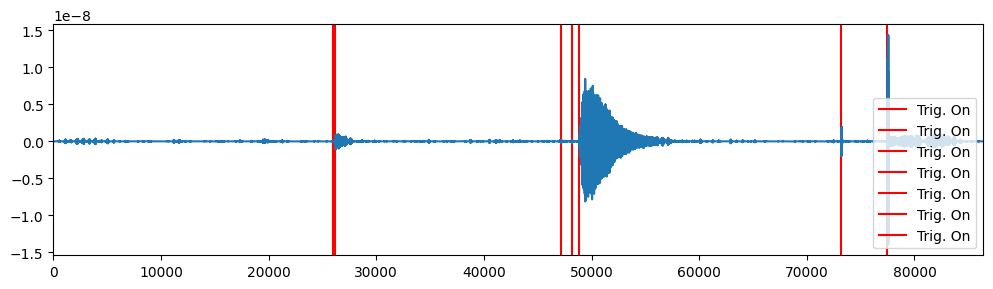

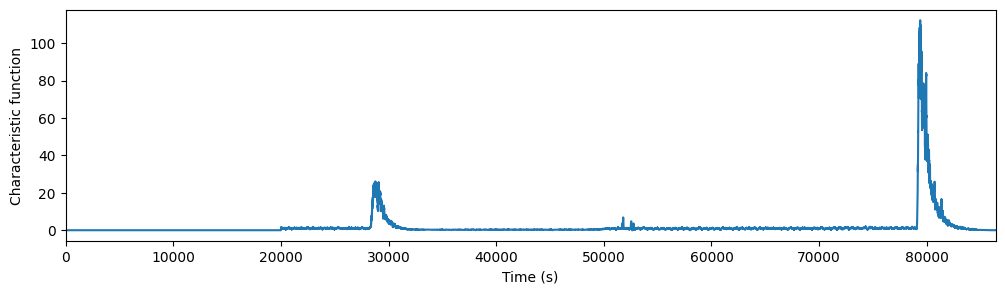

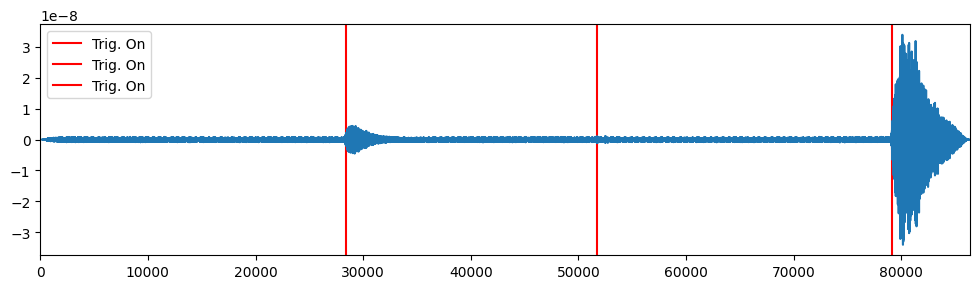

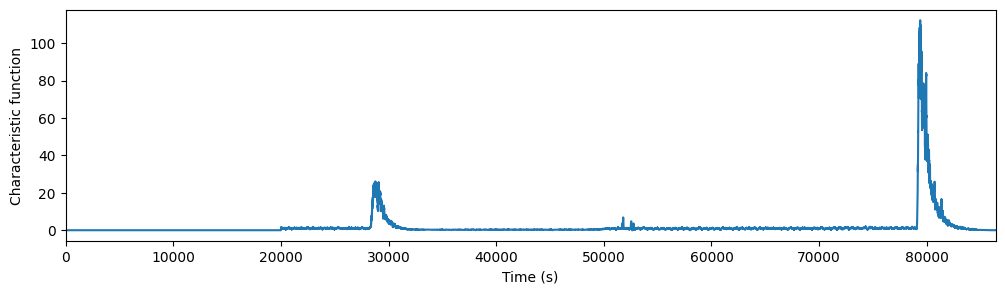

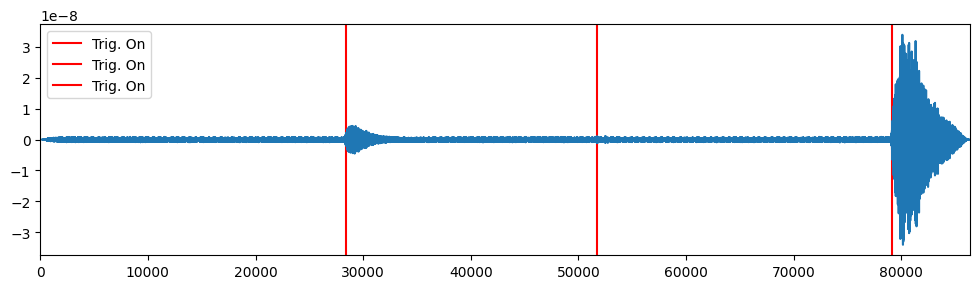

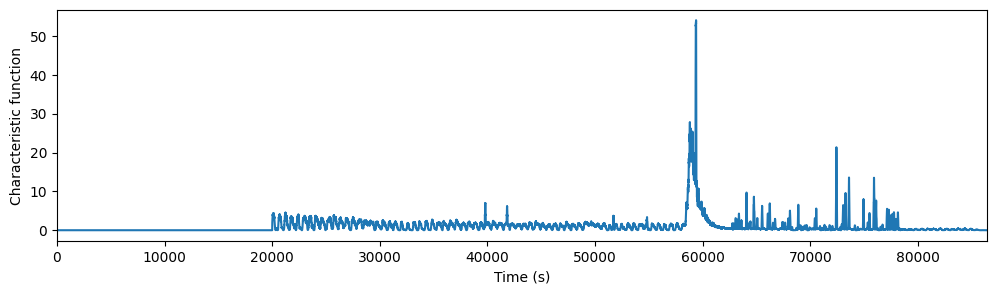

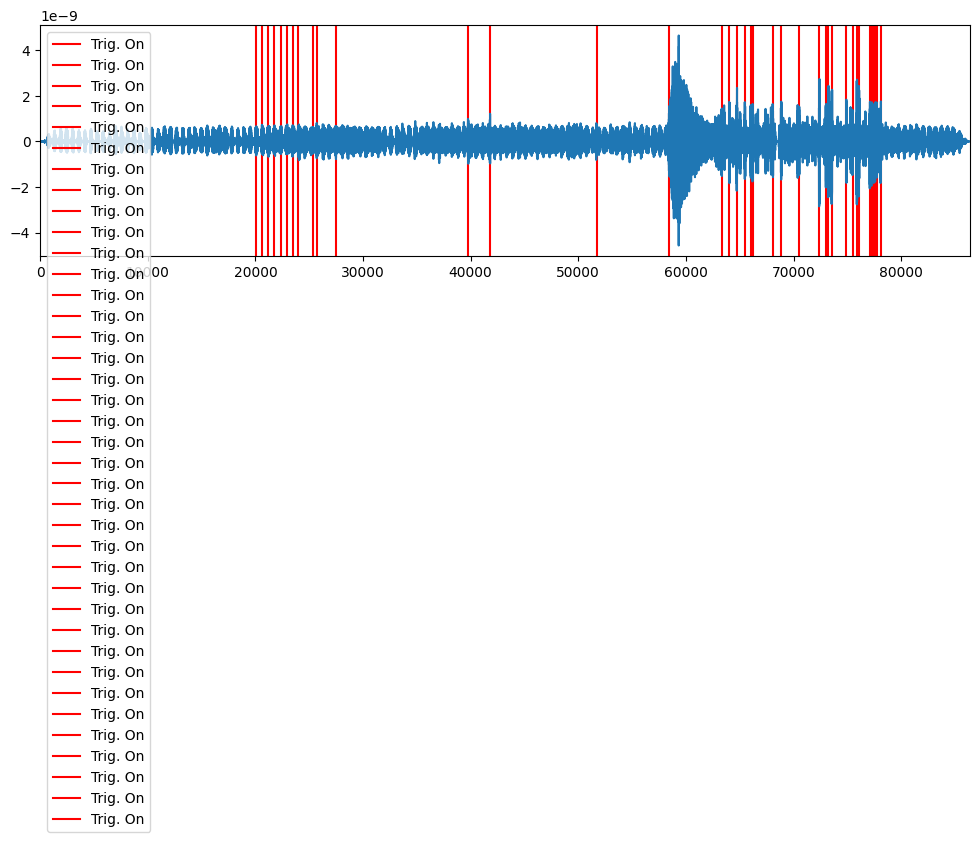

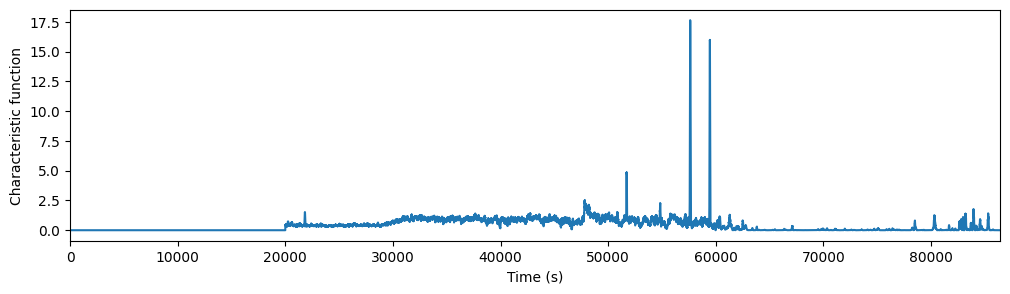

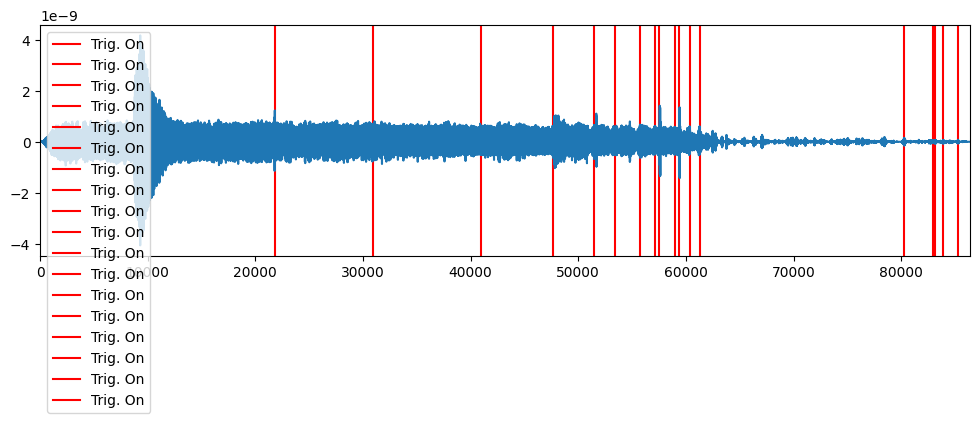

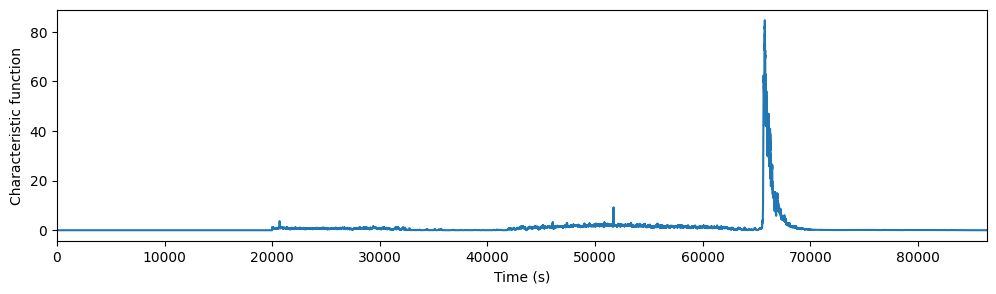

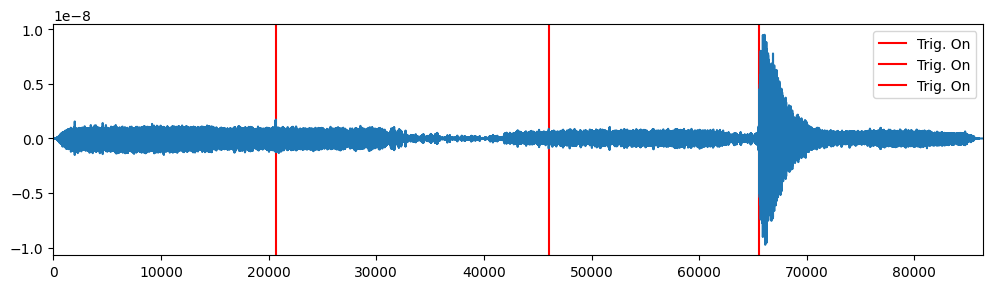

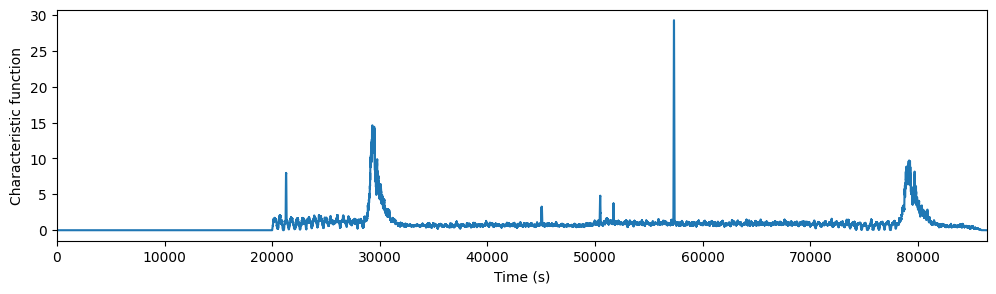

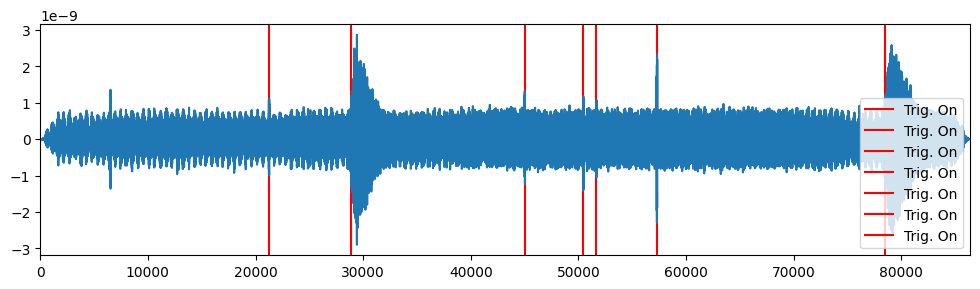

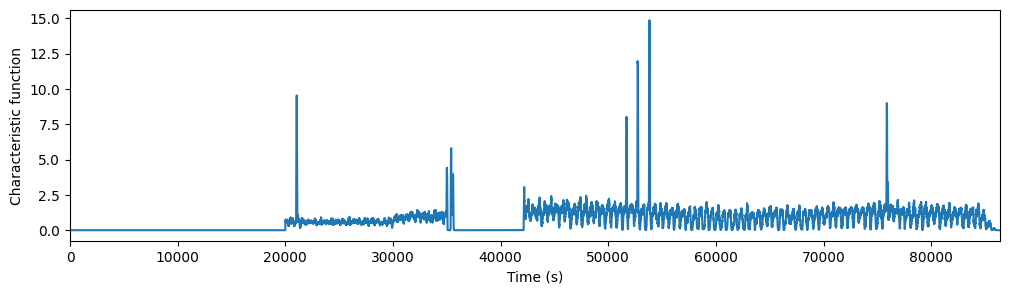

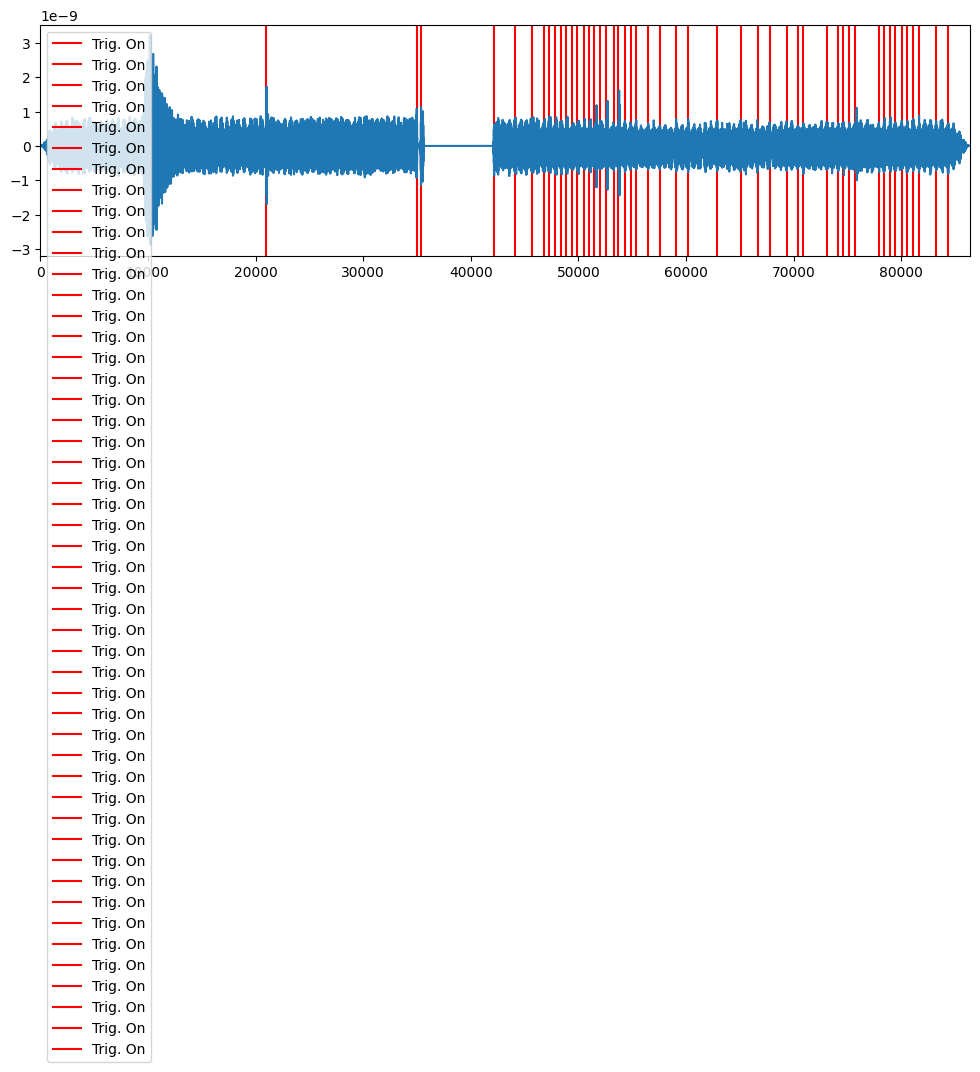

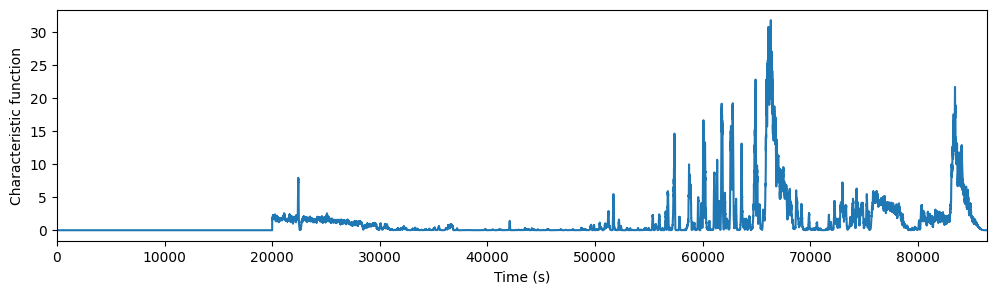

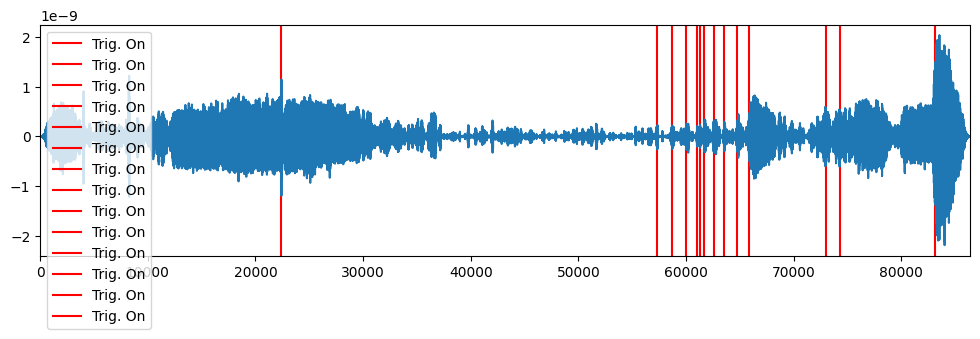

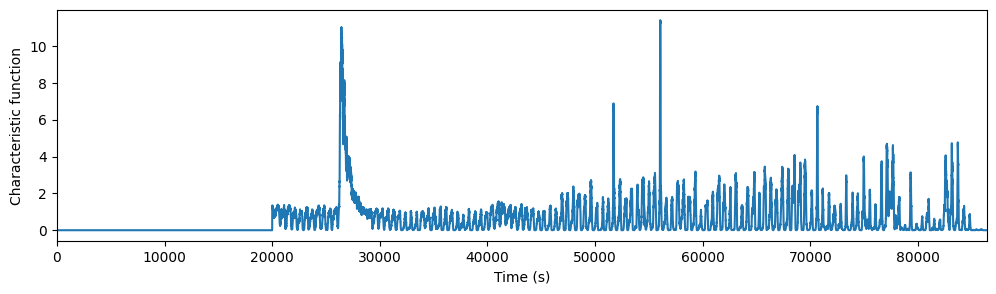

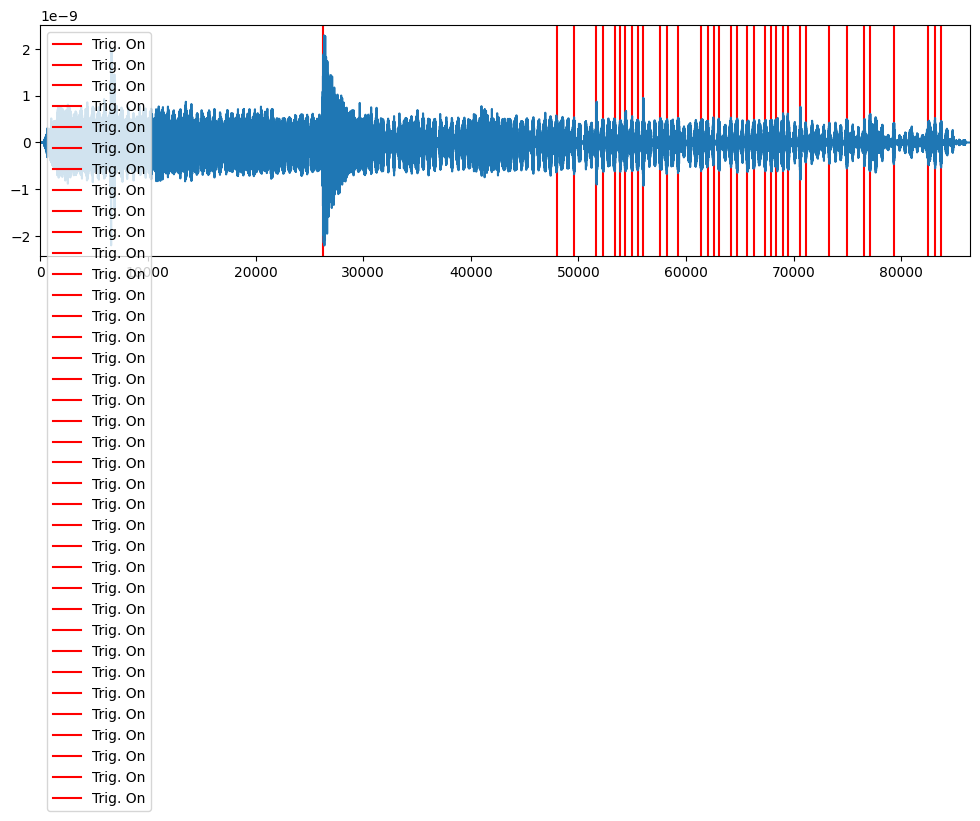

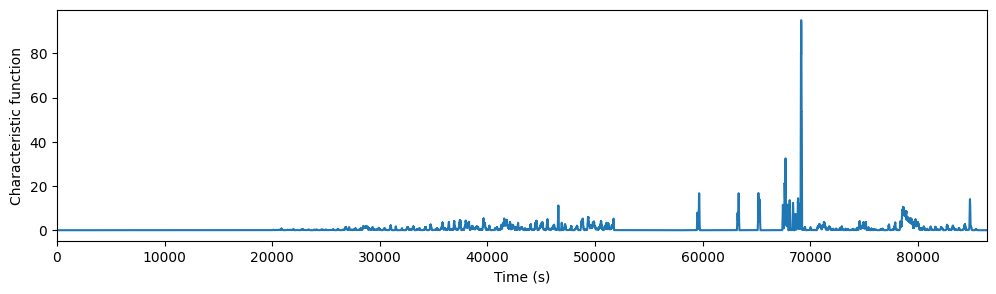

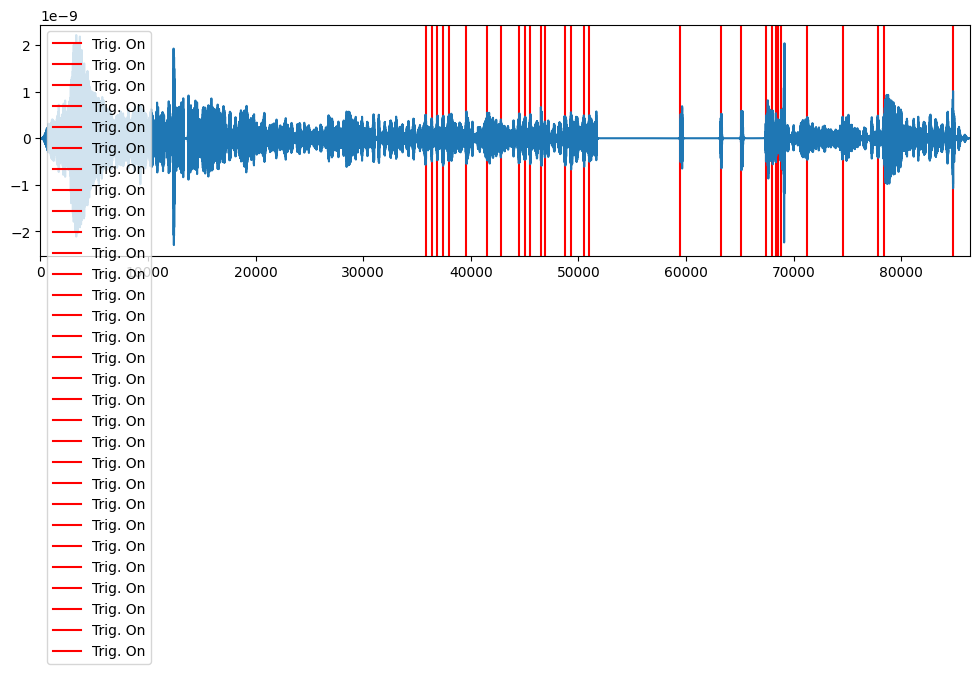

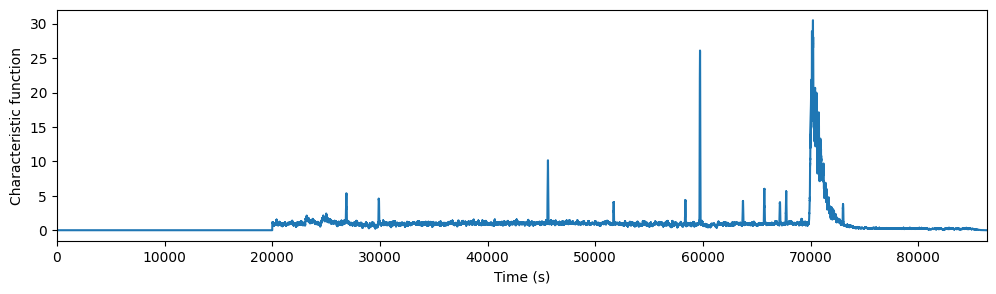

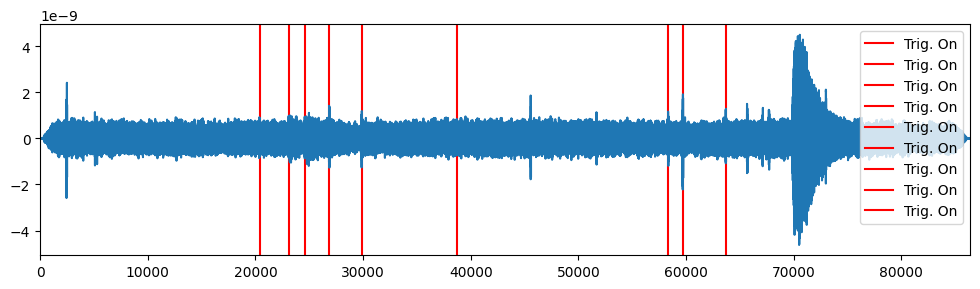

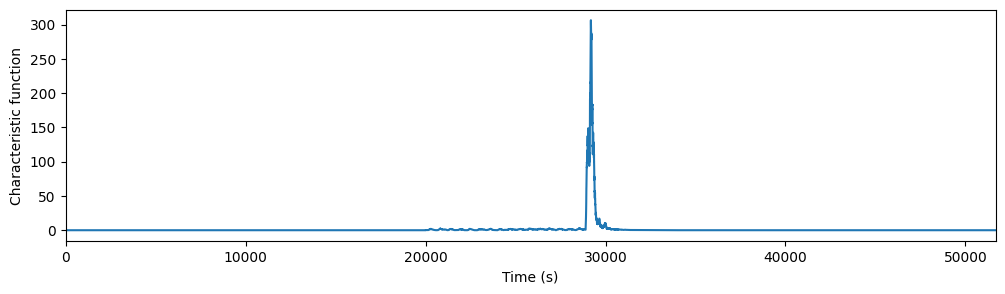

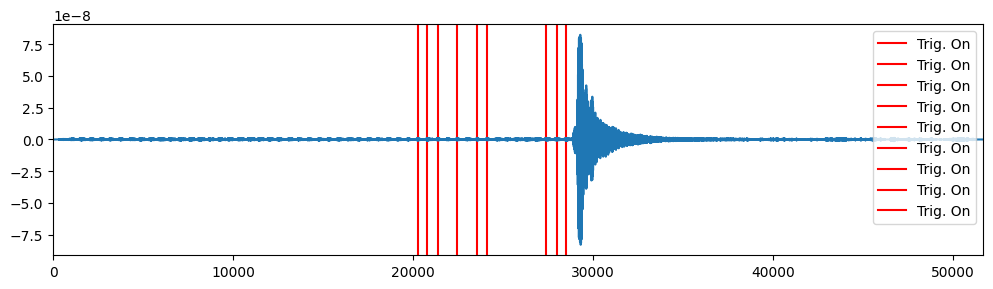

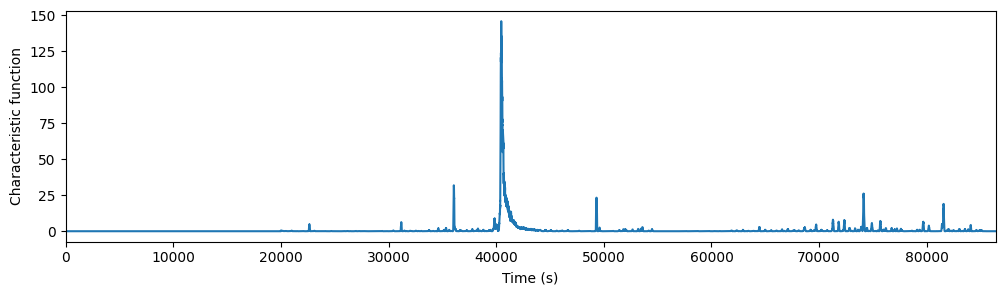

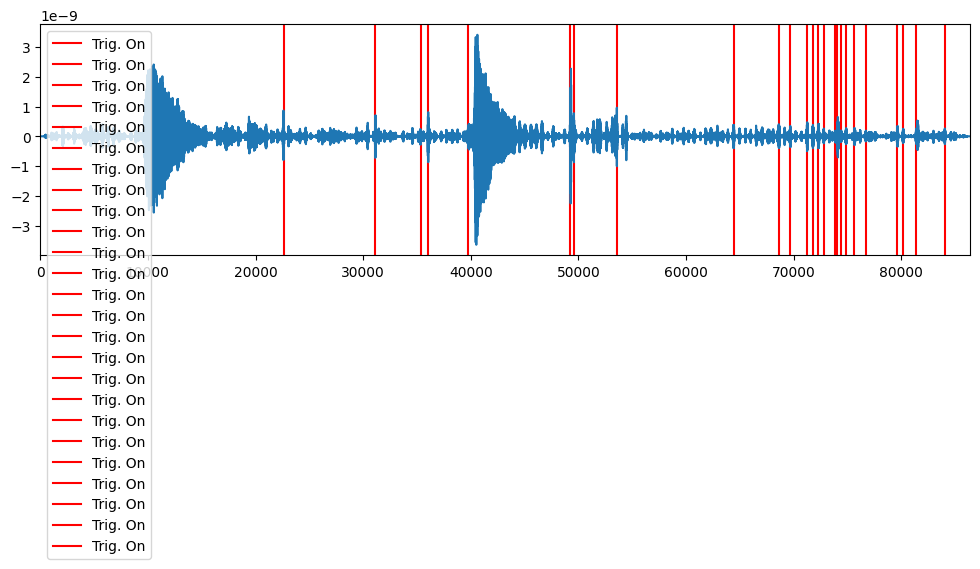

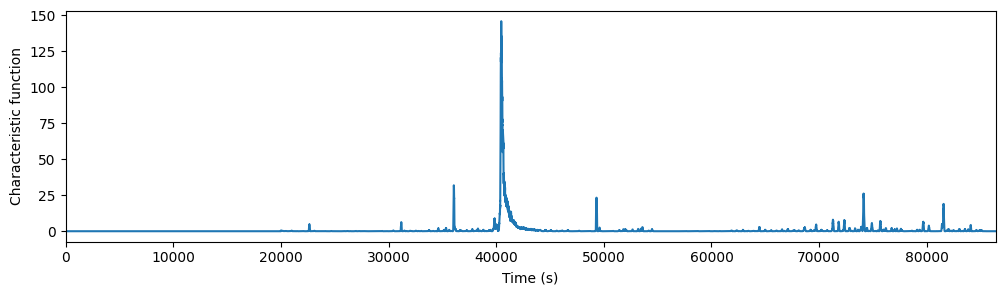

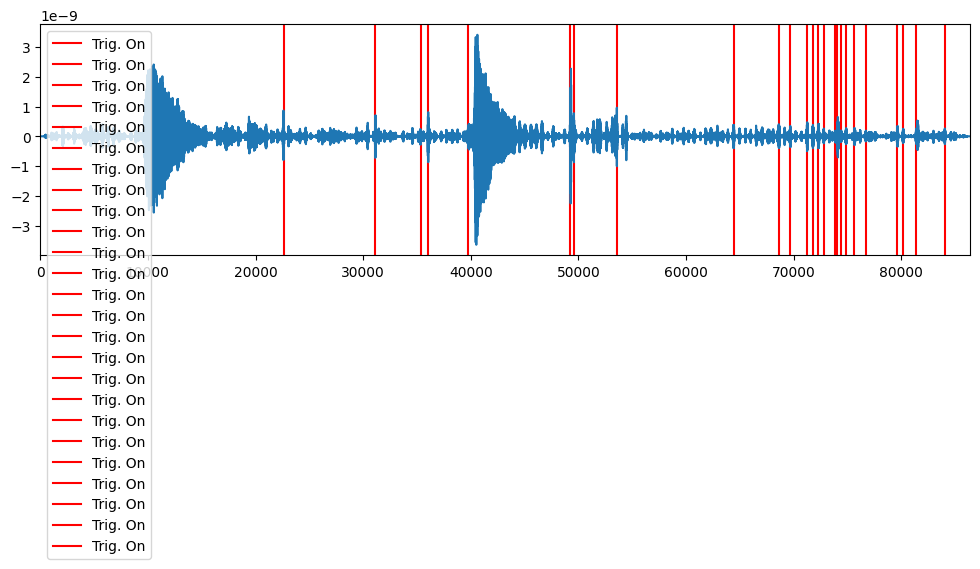

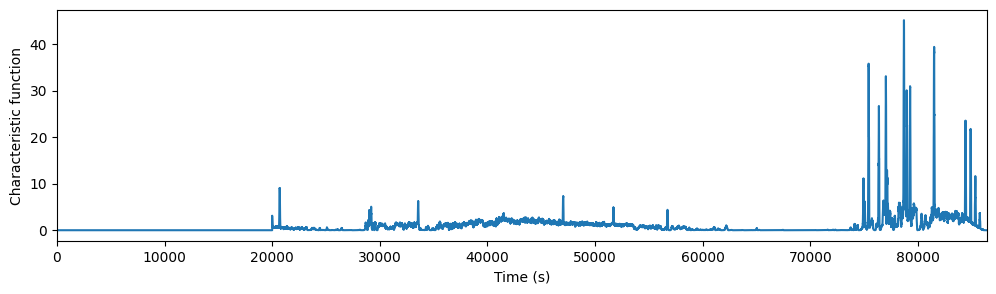

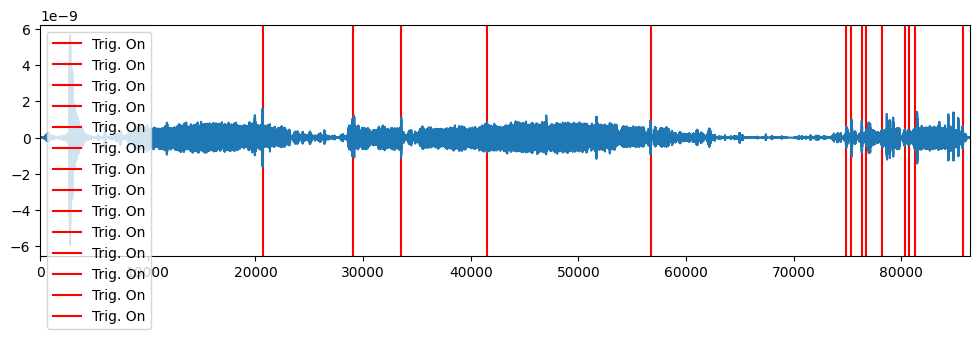

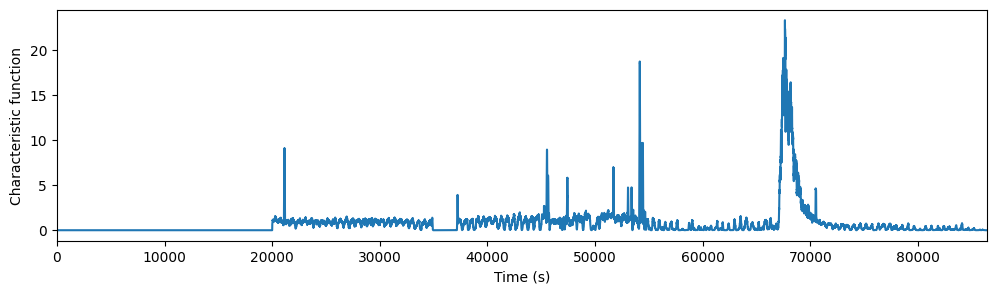

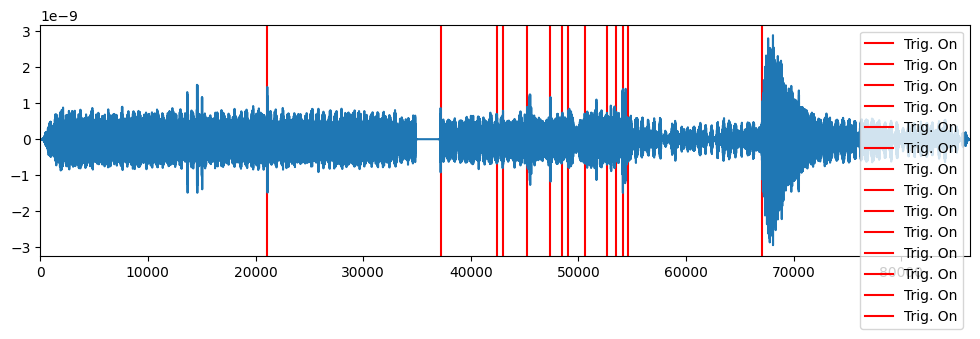

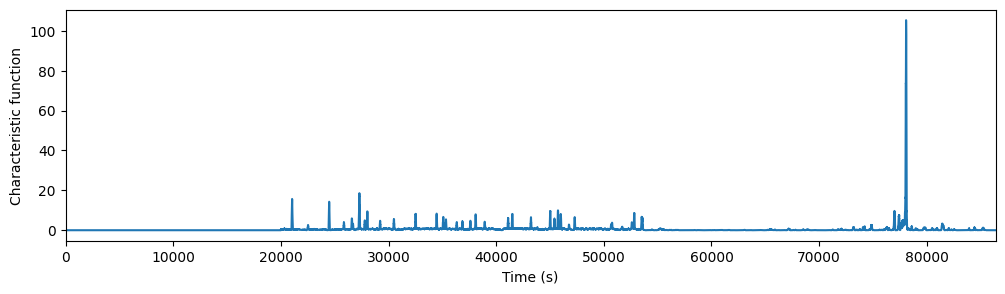

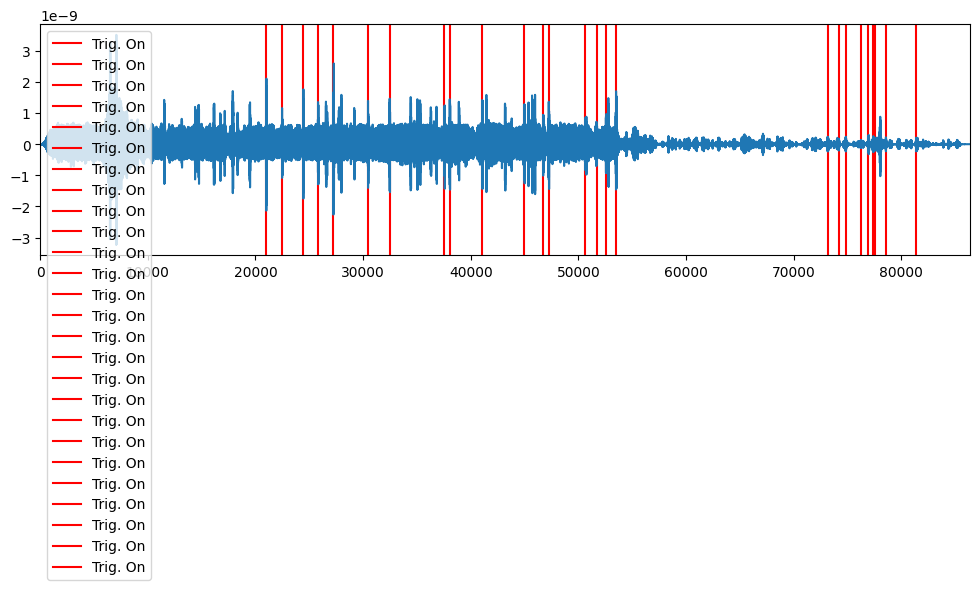

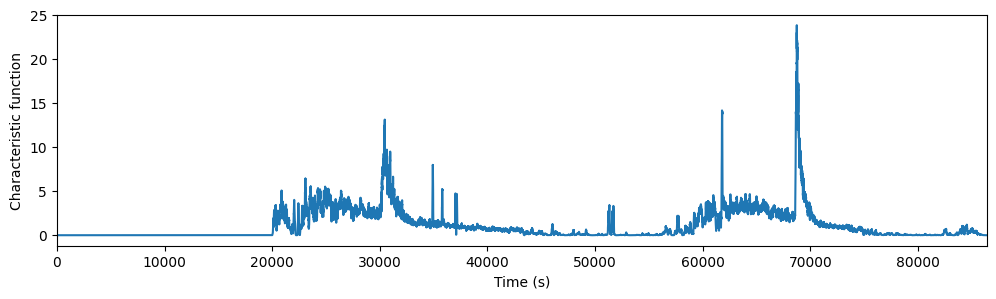

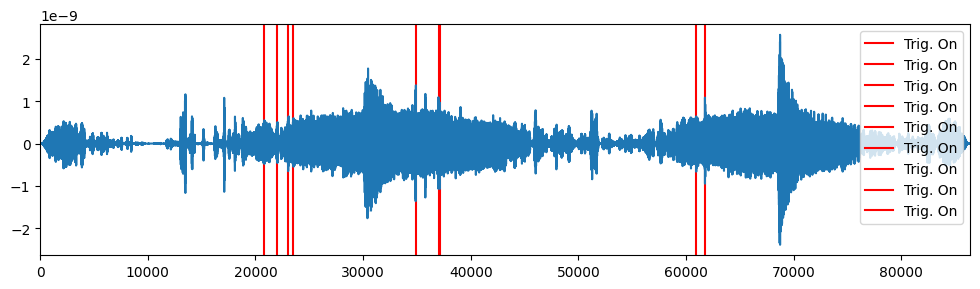

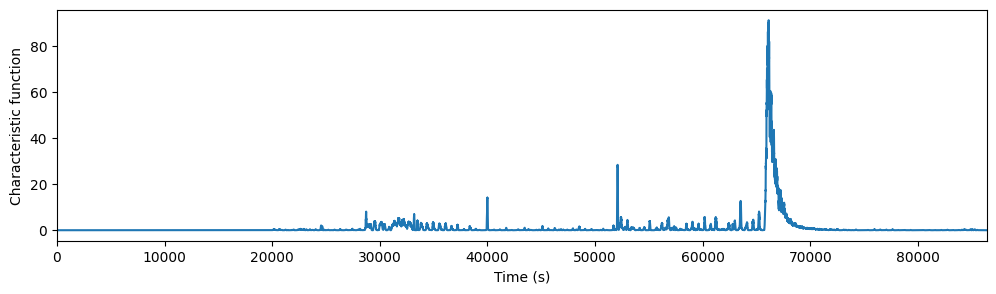

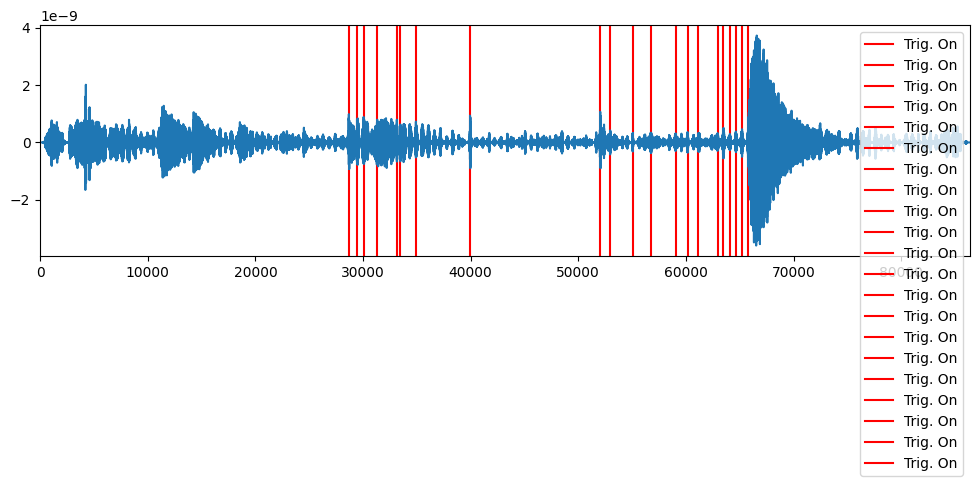

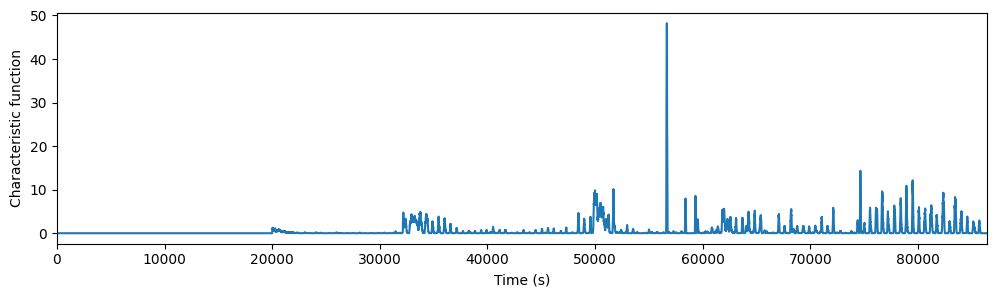

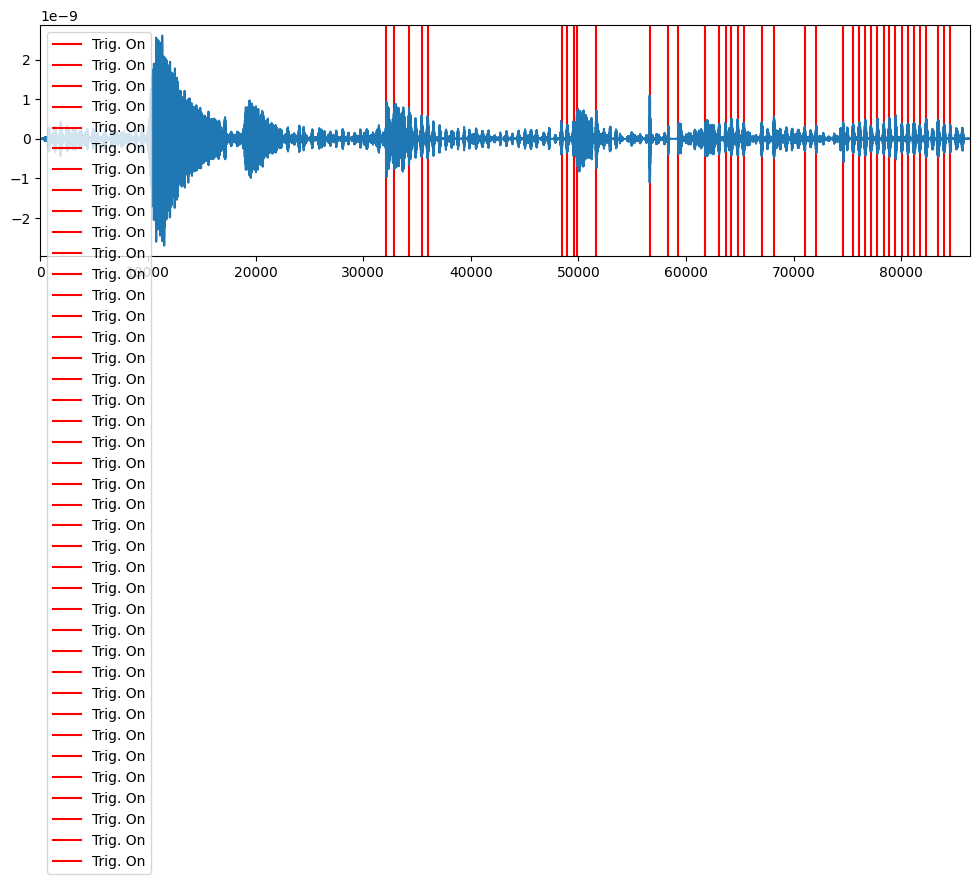

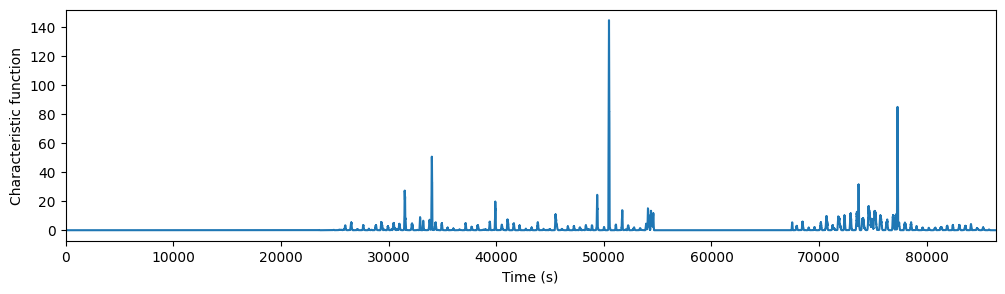

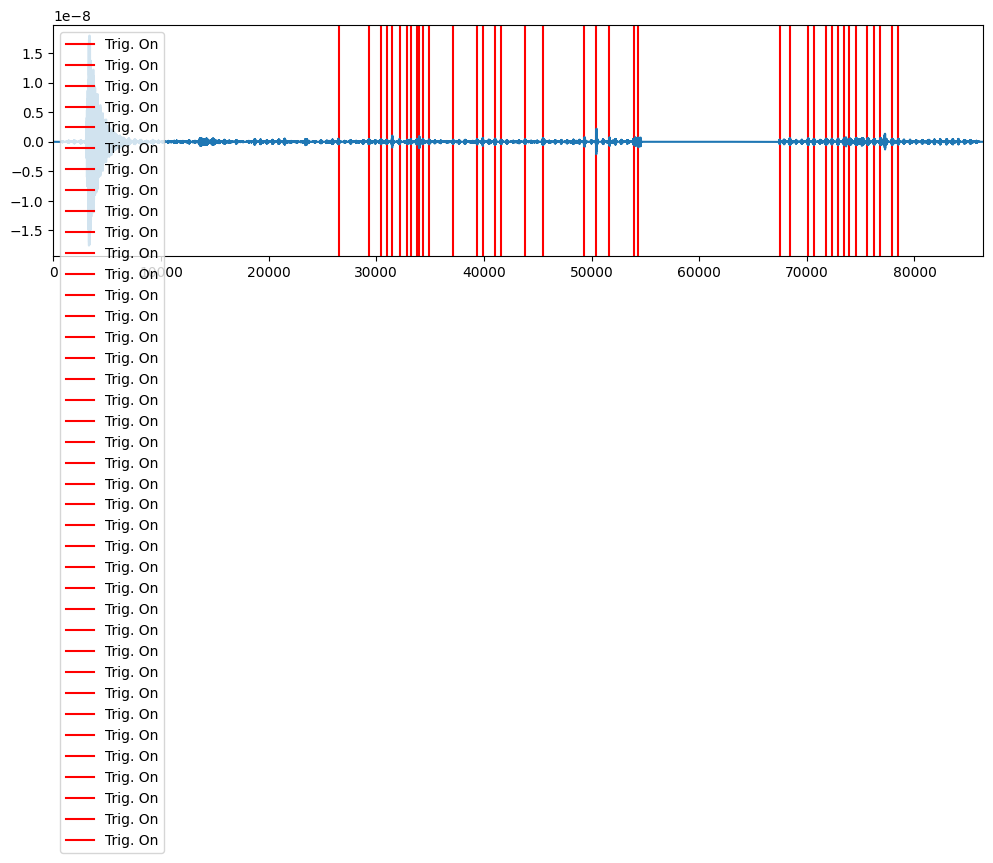

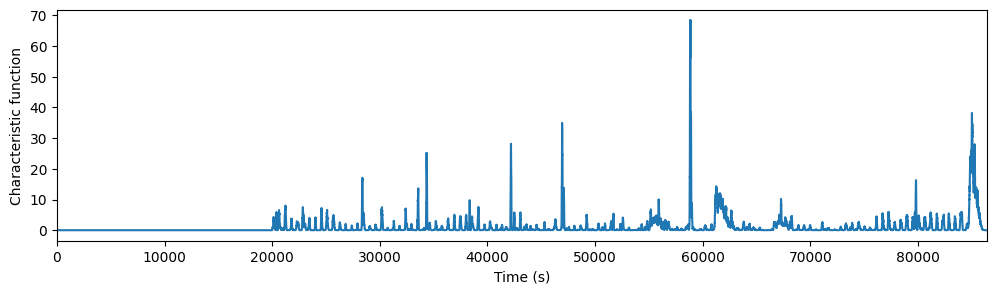

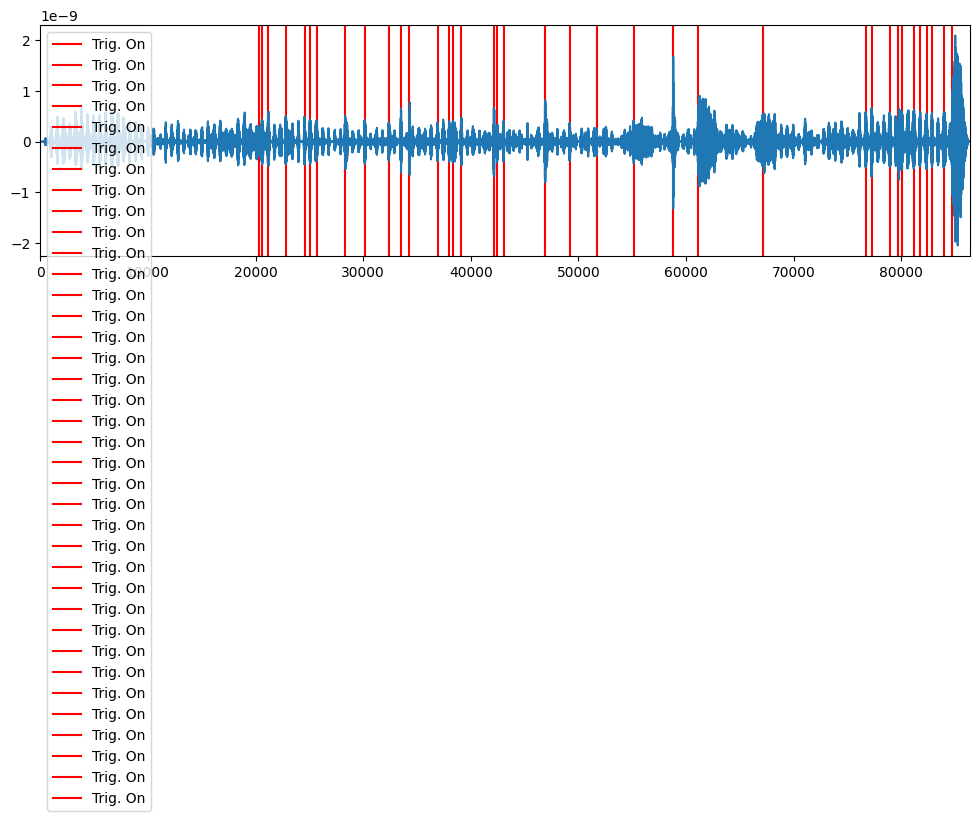

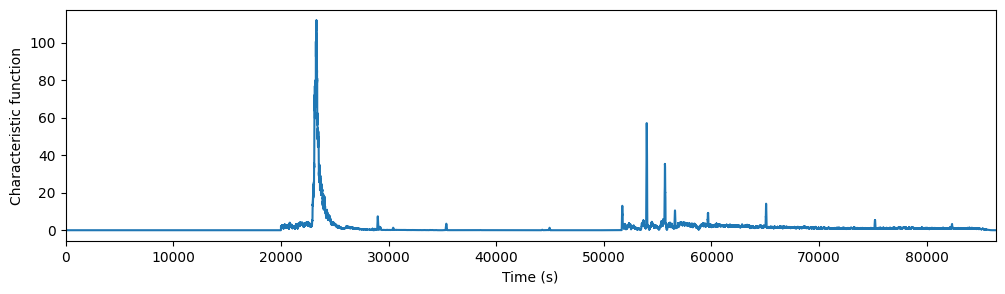

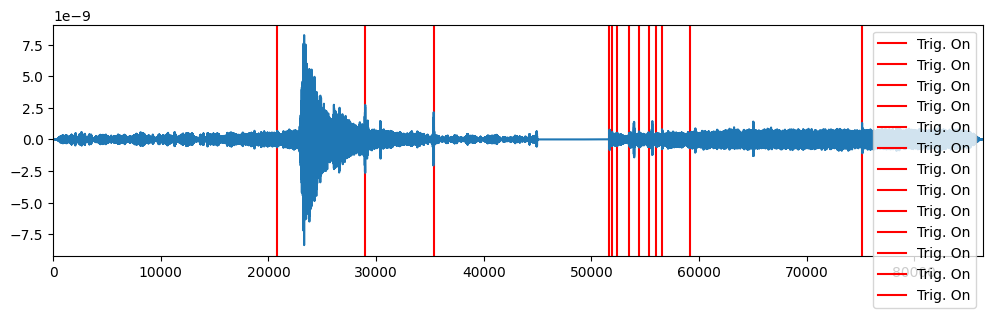

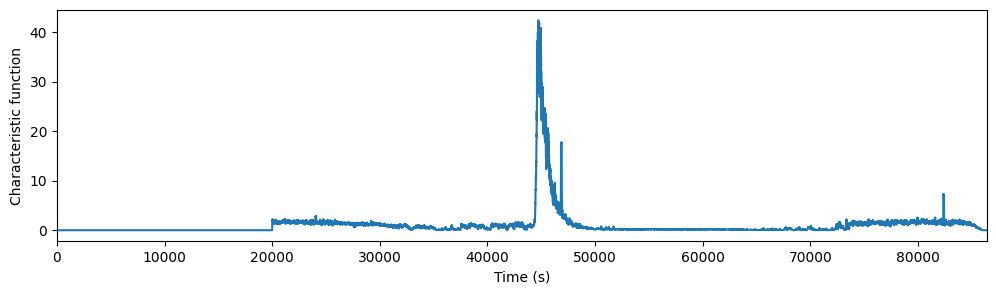

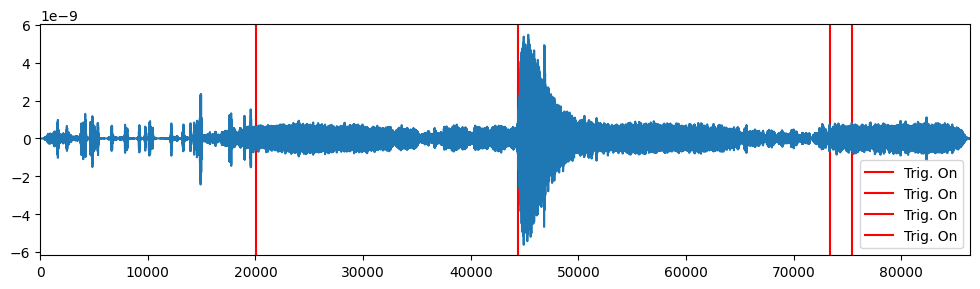

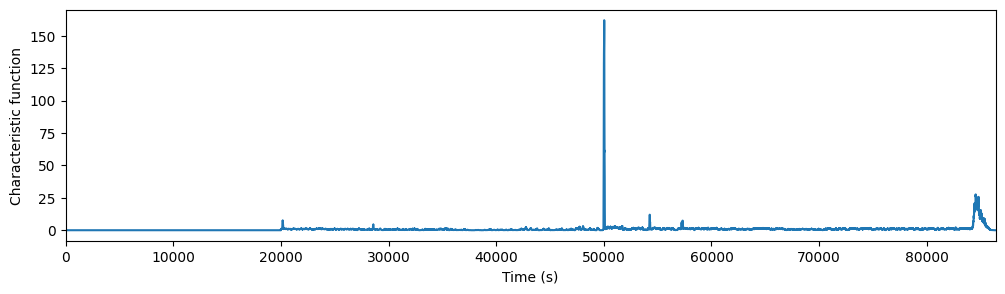

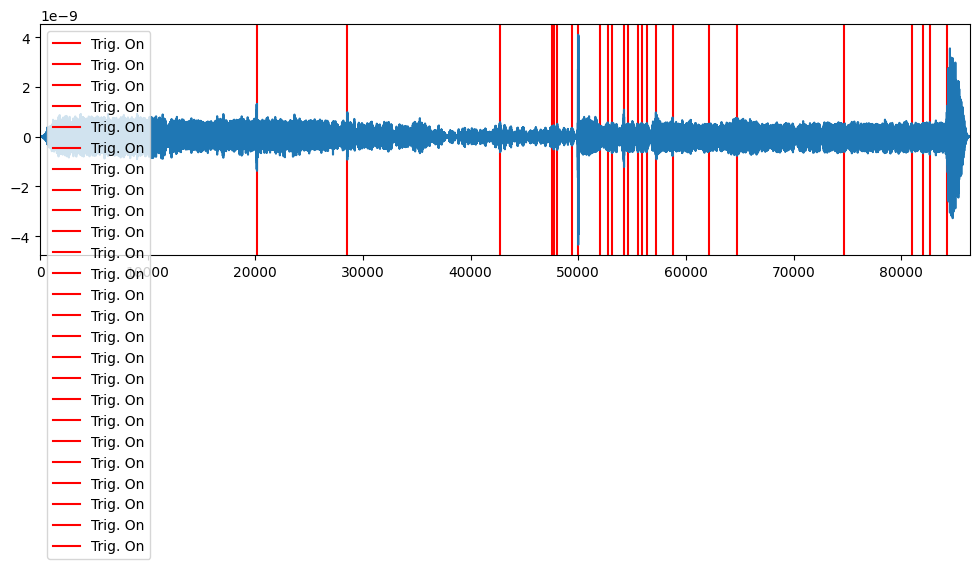

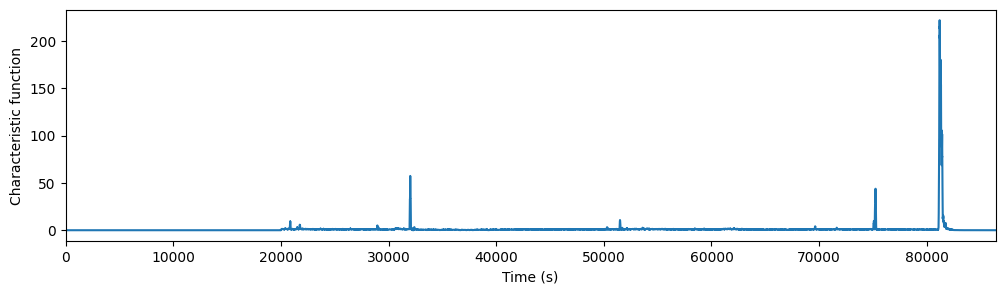

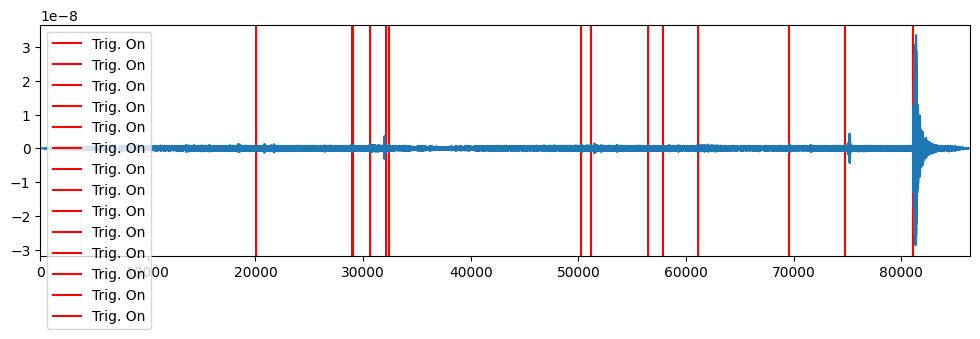

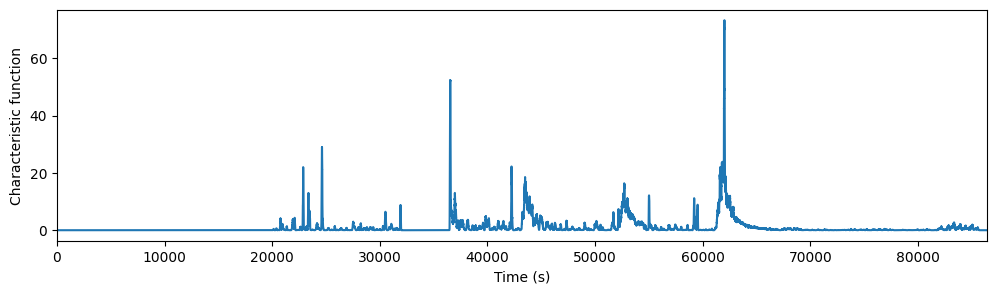

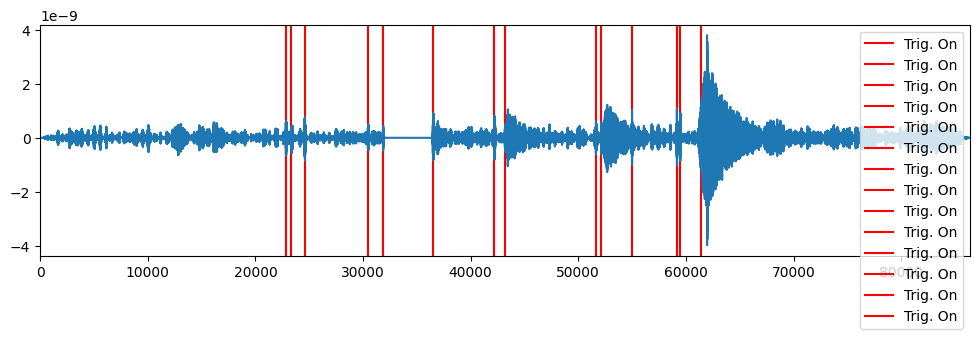

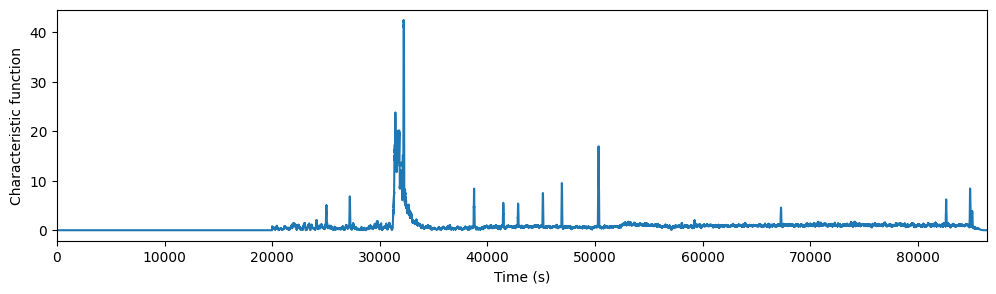

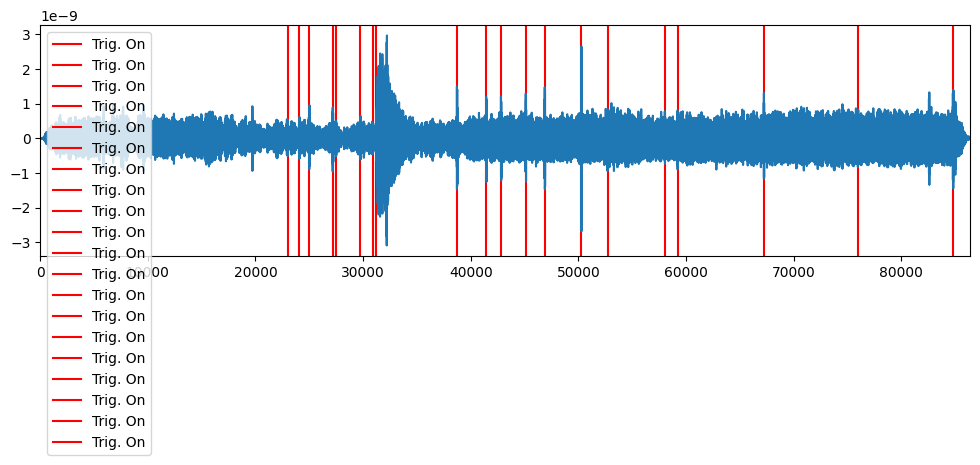

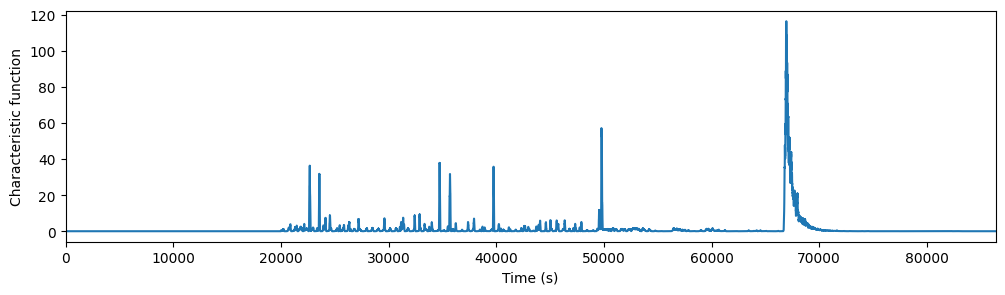

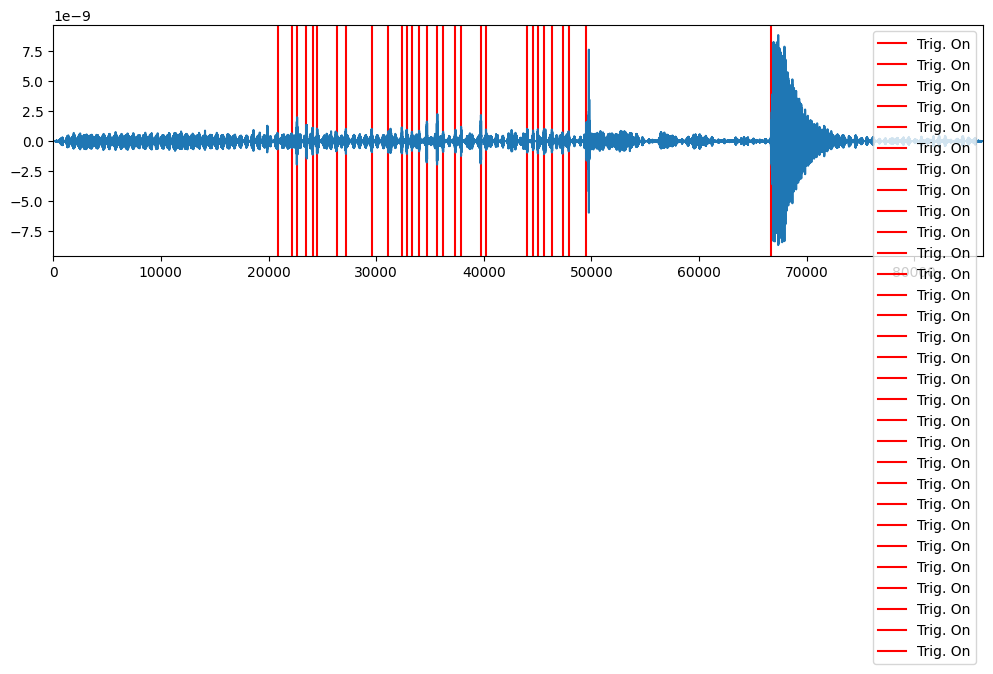

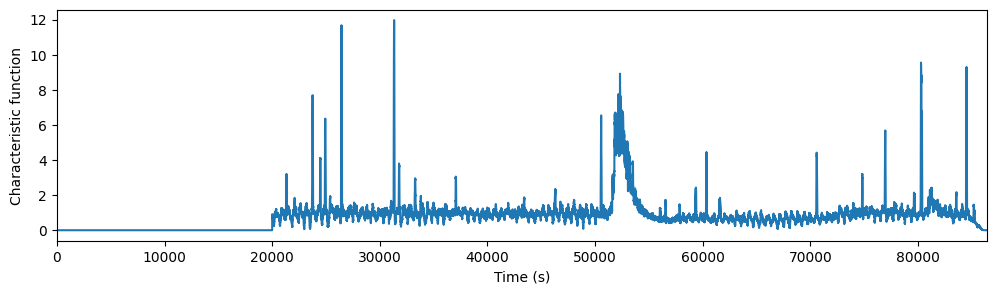

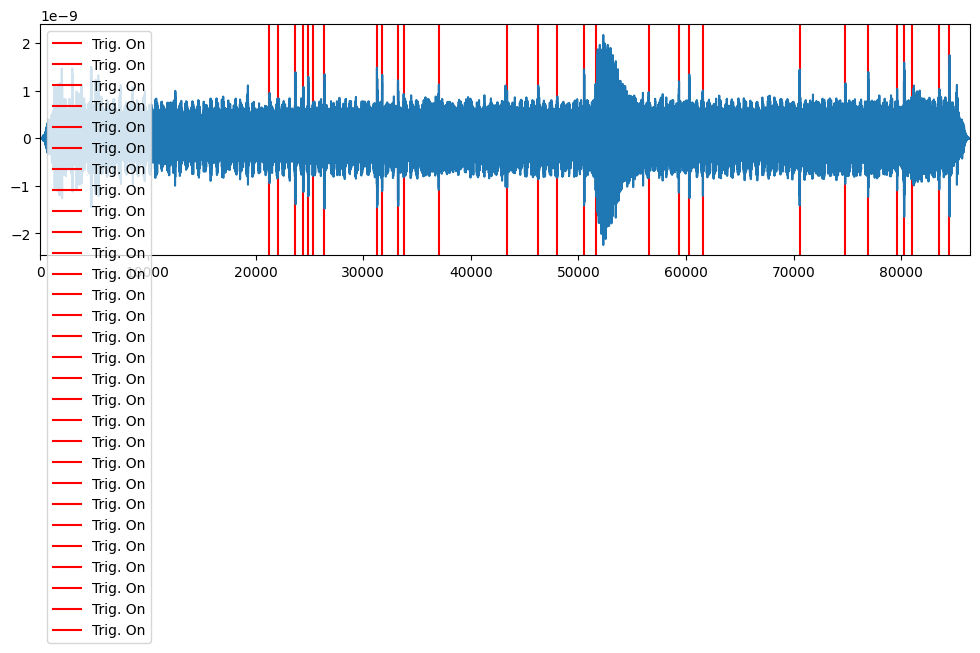

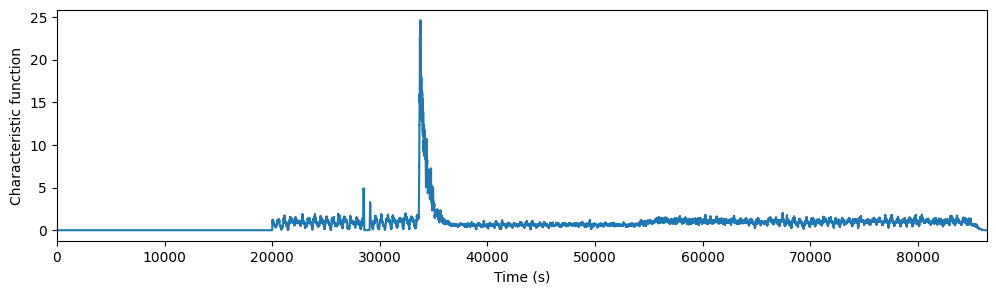

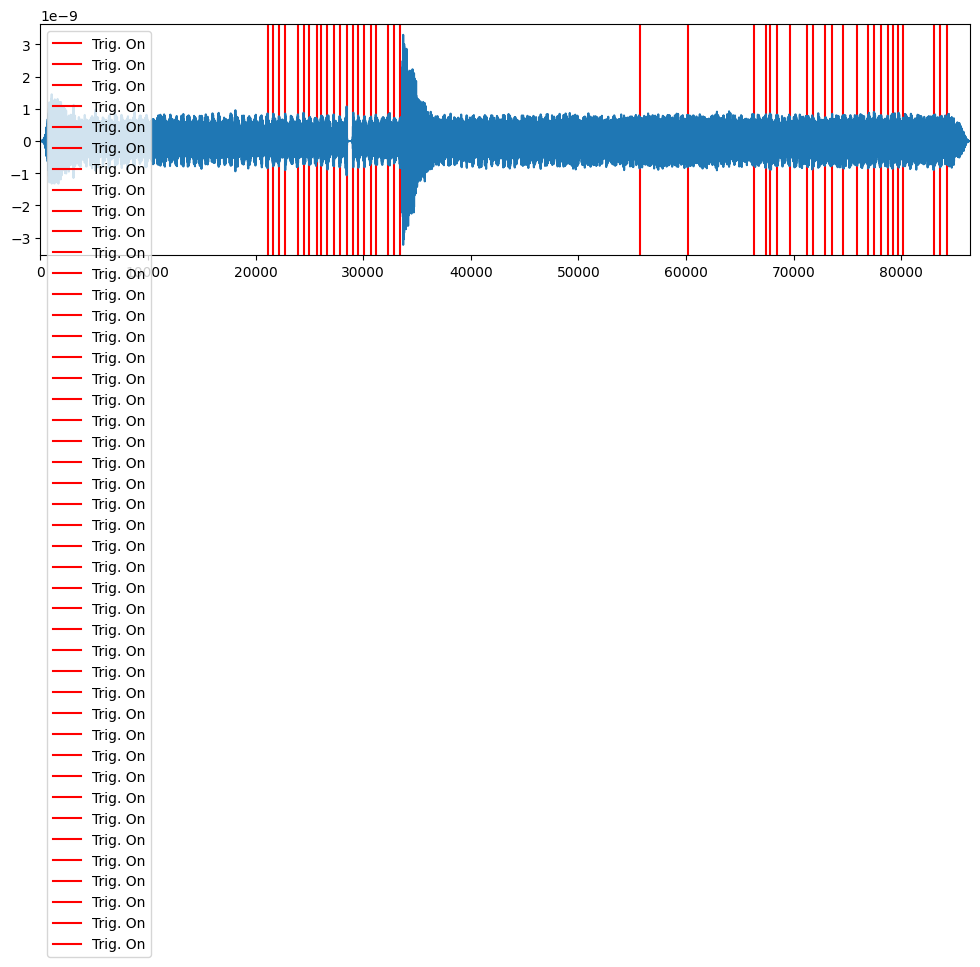

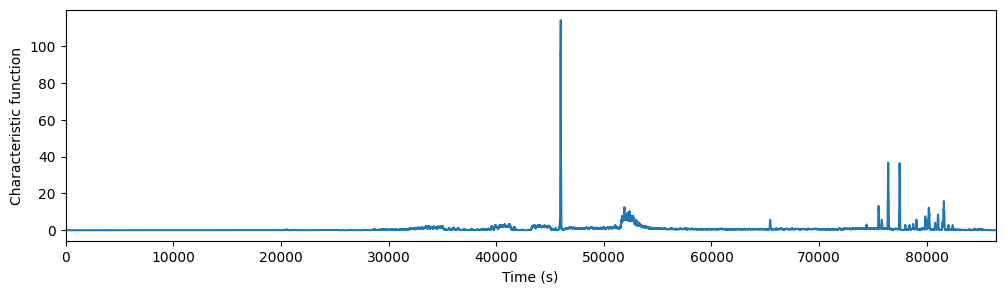

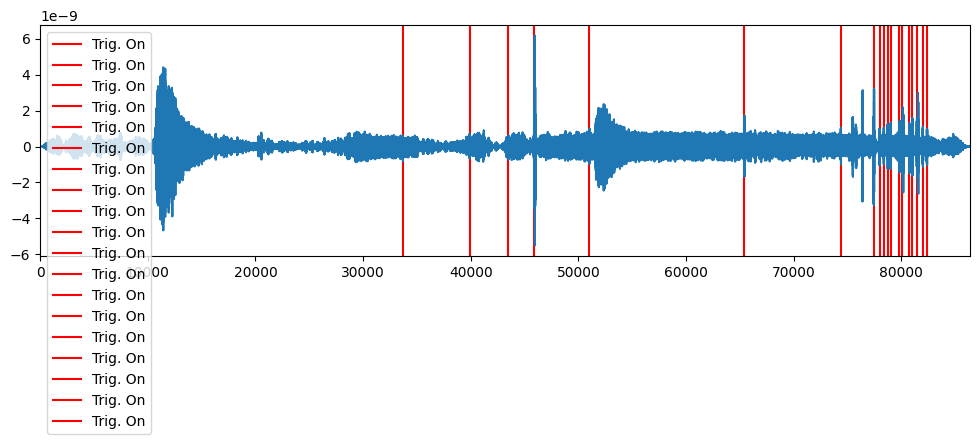

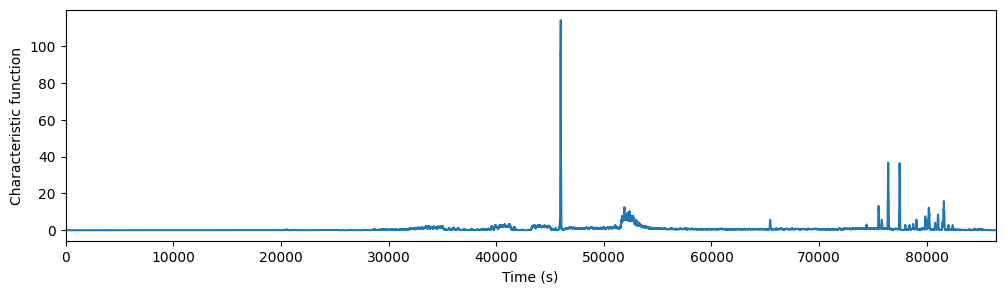

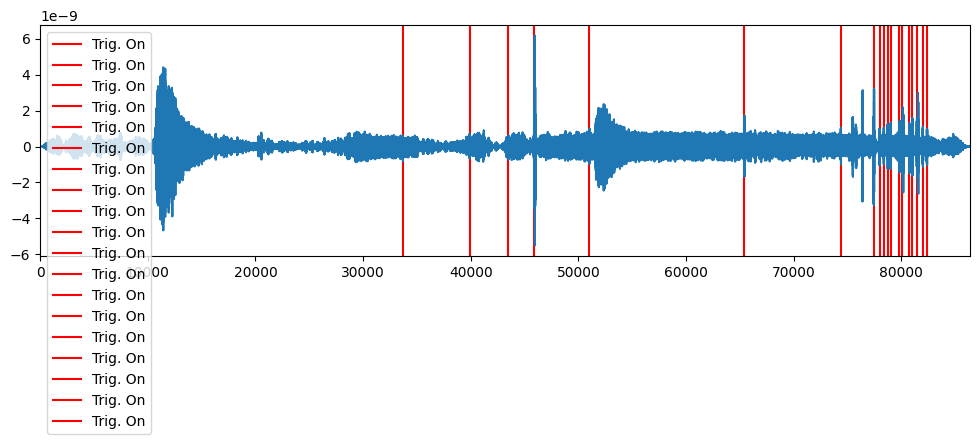

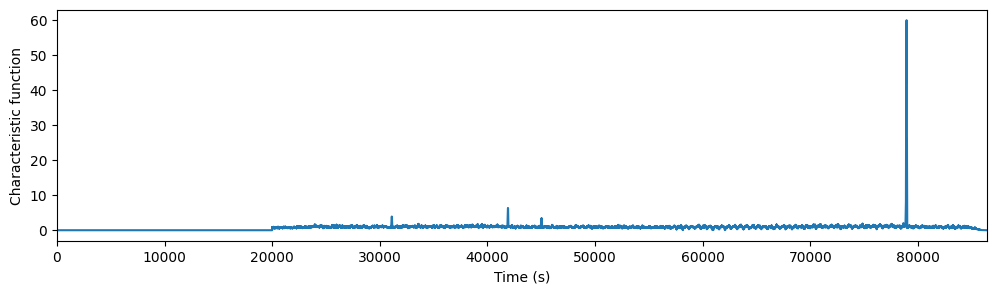

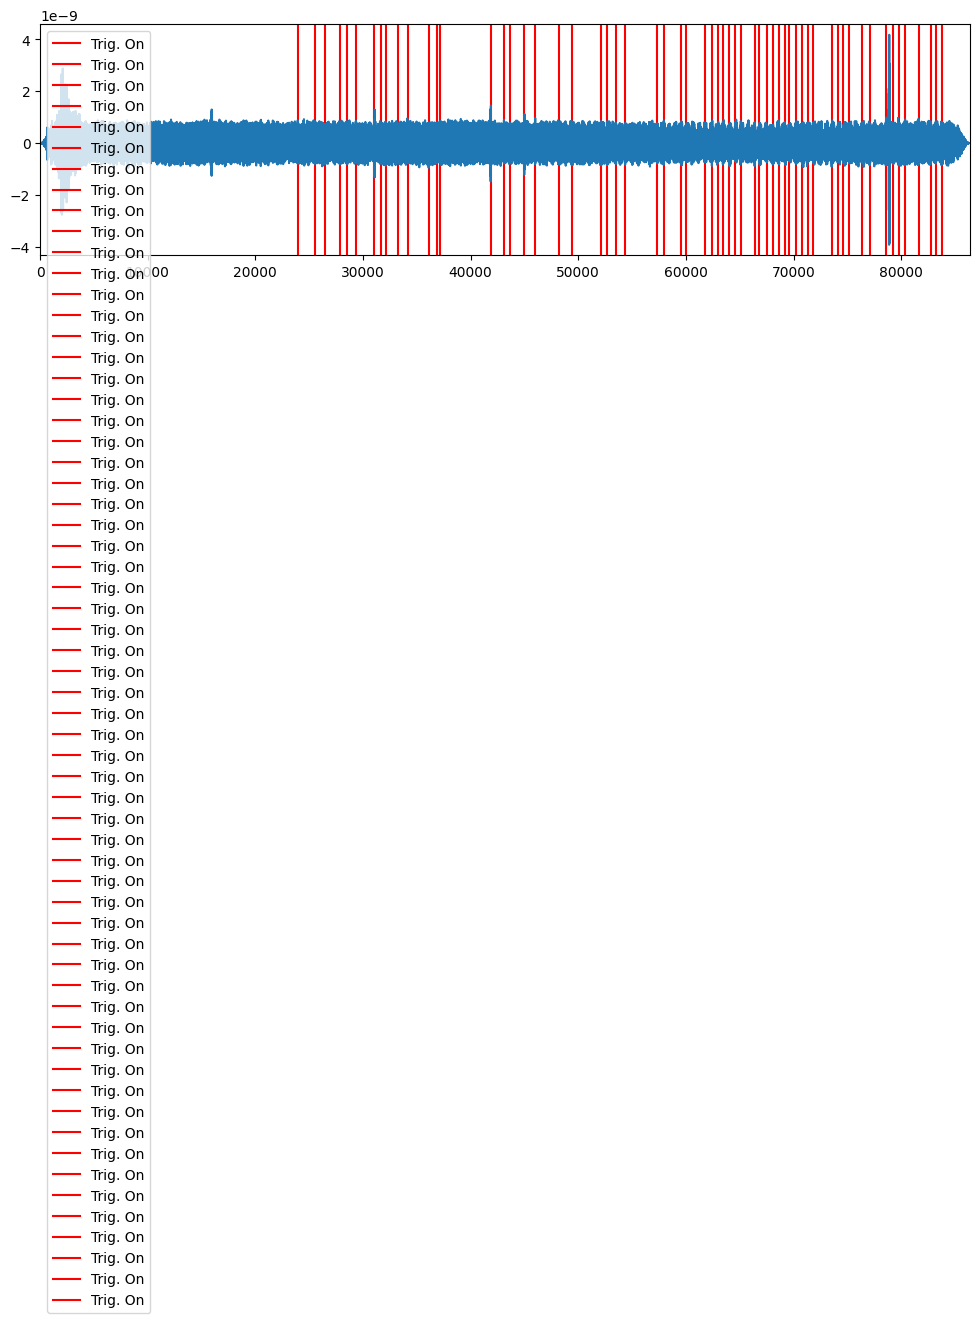

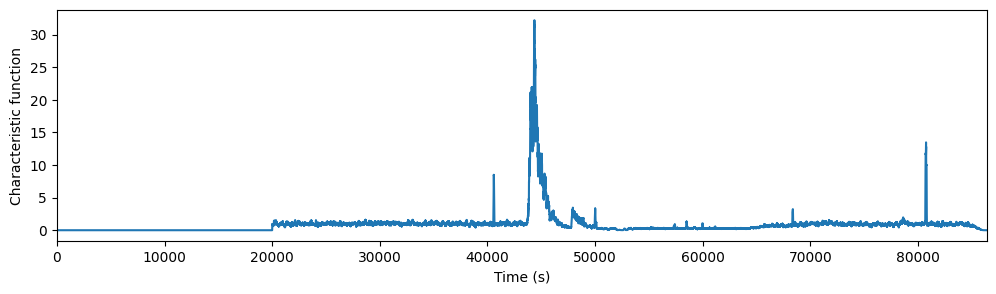

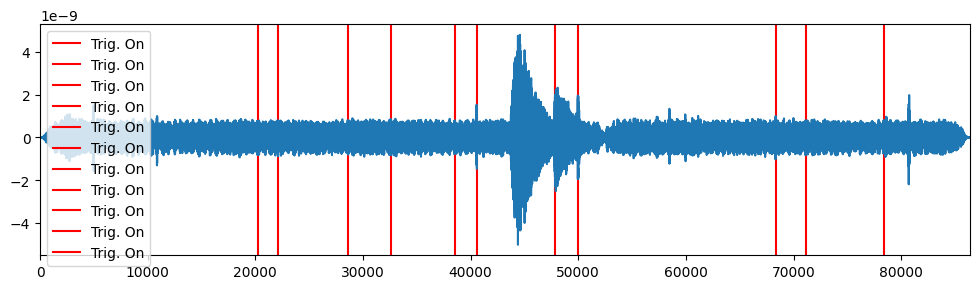

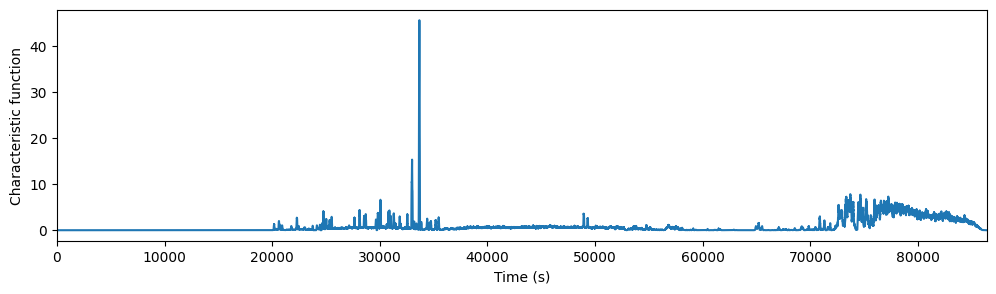

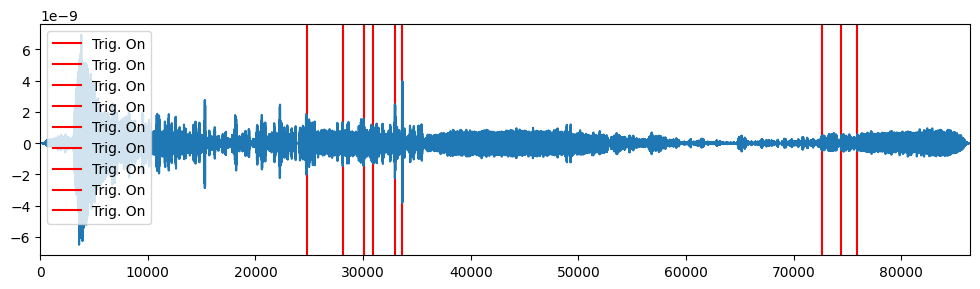

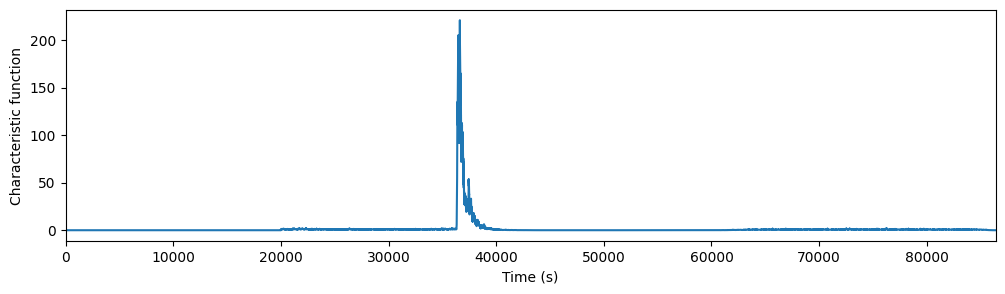

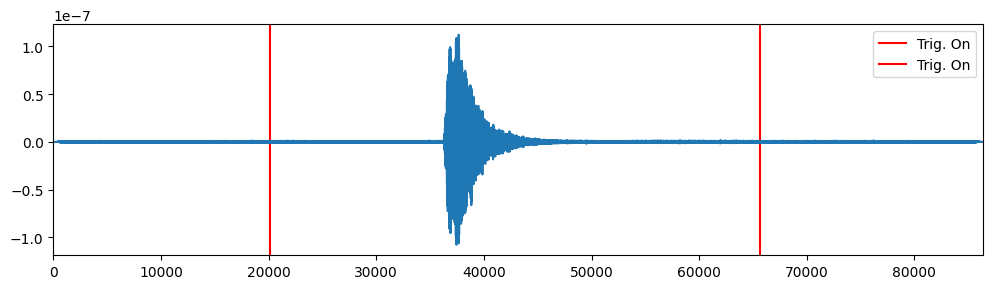

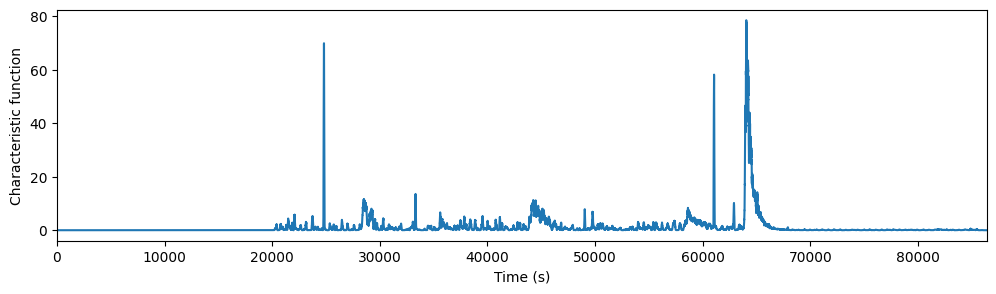

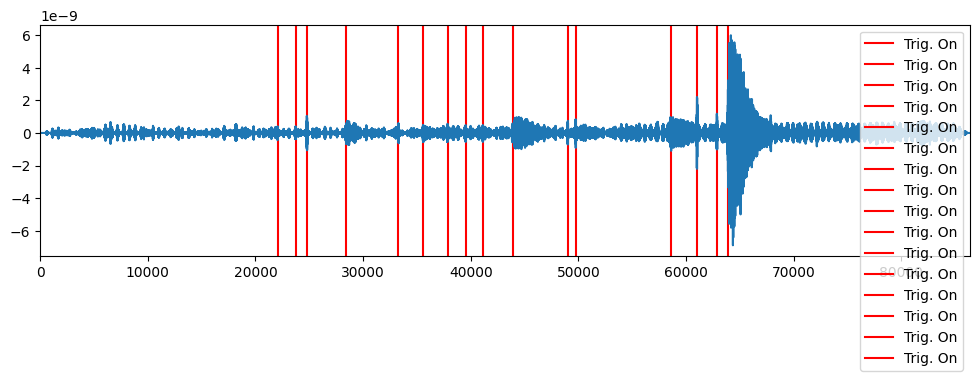

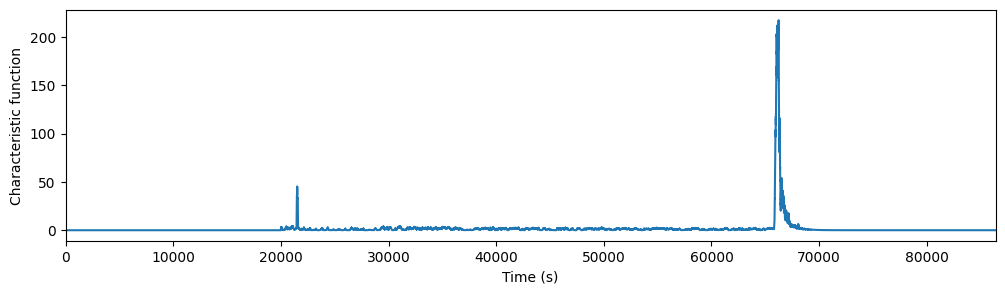

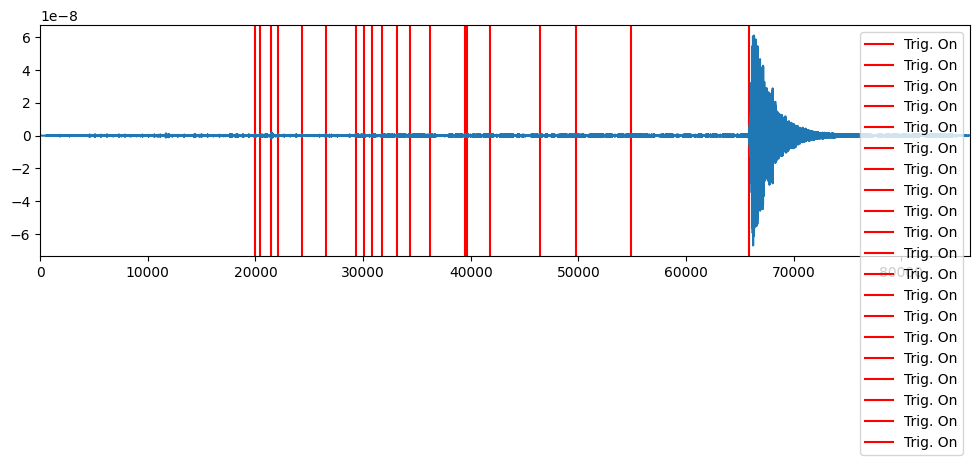

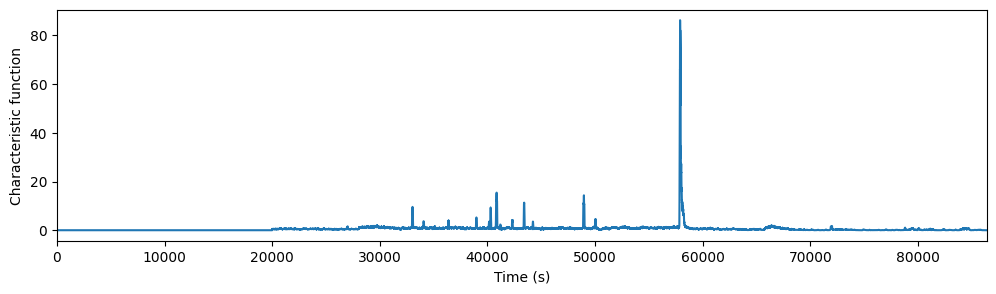

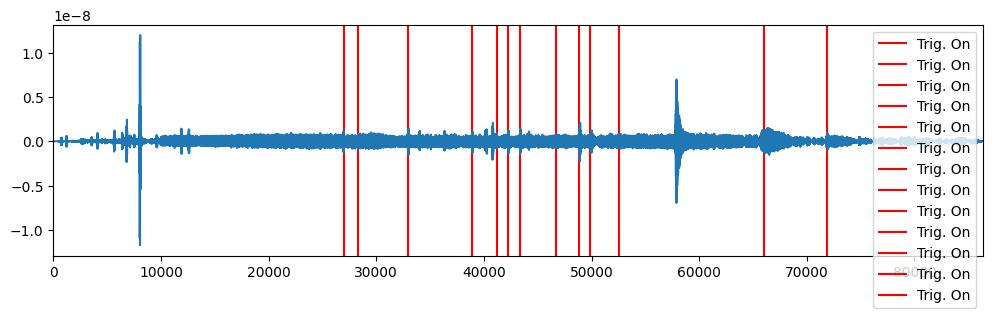

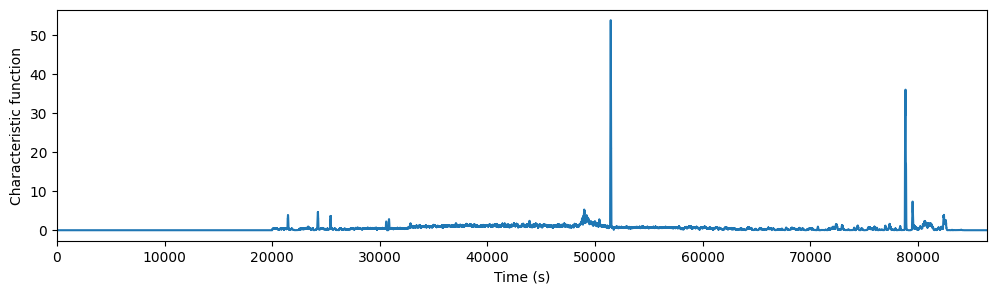

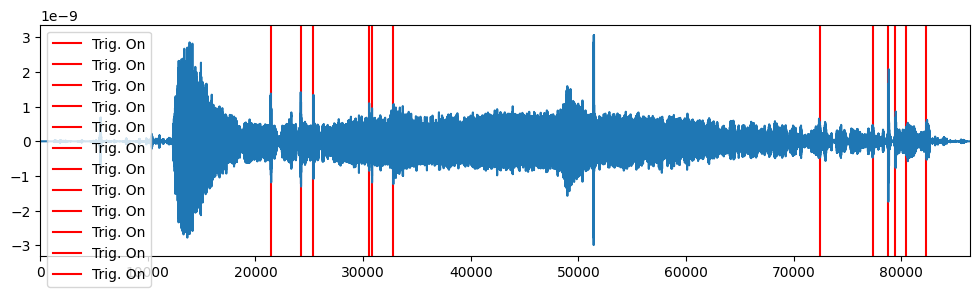

In [26]:
red_lines = await process_miniseed()